<a href="https://colab.research.google.com/github/vladgrish/ds_spac_project/blob/gh-pages/playing_with_prophet_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%matplotlib inline
!pip install plotly
!pip install yahoo_fin
!pip install prophet
import pandas as pd
import numpy as np
import seaborn as sns # !
import matplotlib.pyplot as plt # !
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import plotly.express as px
from yahoo_fin.stock_info import get_data
from google.colab import drive
import requests
from datetime import datetime, date, timedelta

# to pre-process model inputs
from sklearn import preprocessing 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import gradient_descent_v2 #SGD
import math
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# clustering algorithm
from sklearn.cluster import KMeans

sgd = gradient_descent_v2.SGD(...)

mergers = pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/merger_spacs.csv')
pending_mergers =  pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/pending_spac_mergers.csv')

# some additional settings for sns
sns.set()
sns.set(rc={"figure.figsize": (20, 10)})
PALETTE = sns.color_palette('deep', n_colors=3) # will be used for cmap which is a parameter of seaborn scatter
CMAP = ListedColormap(PALETTE.as_hex()) # A Colormap instance or registered colormap name. cmap is only used if c is an array of floats.
RANDOM_STATE = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# reading all datasets with additional metrics from github (1 minute comparing to 8 when using yahoo api, gdrive is no better...)
# this is the final section for getting the data
def get_symbol_data(ticker):
  df = pd.read_csv(f'https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/stock_csv_data/{ticker}.csv', index_col=0)[1:]
  df.index = pd.to_datetime(df.index)
  return df

merged_symbols = mergers['Symbol'].values.tolist()
pending_mergers_symbols = pending_mergers['Symbol'].values.tolist()

if 'dfs' not in globals(): # or True:
  dfs = {}
  for x in merged_symbols+pending_mergers_symbols:
     dfs[x] = {}
     dfs[x]['data'] = get_symbol_data(x)

For exploration purposes we will calculate additional metrics for each symbol:

- maximum closing price at which the stock was traded and it's date
- minimum closing price and it's date
- whole stock trading dataset size
- dataset sizes before and after the peak (crucial for understanding whether enough data is available to train a model)
- average stock price before the price peak
- potential return on investment if bought at average price and sold at peak  with an adjustment of 70% accuracy (no one can ever predict the exact peak)

In [99]:
from operator import index
for x in merged_symbols:
  df = dfs[x]['data']
  dfs[x]['symbol'] = x
  dfs[x]['first_date'] = df.index[0]
  dfs[x]['dataset_size'] = df.index.size
  dfs[x]['dataset_size_before_peak'] = df[:dfs[x]['max_price_date']].index.size
  dfs[x]['dataset_size_after_peak'] = df[dfs[x]['max_price_date']:].index.size
  dfs[x]['max_price_date'] = df['close'].idxmax()
  dfs[x]['max_price'] = df['close'].max()
  dfs[x]['min_price'] = df['close'].min()
  dfs[x]['min_price_date'] = df['close'].idxmin()
  dfs[x]['average_price_before_peak'] = df[:dfs[x]['max_price_date']-timedelta(days=3)]['close'].mean()
  dfs[x]['potential_investment_return'] = (dfs[x]['max_price'] - dfs[x]['average_price_before_peak']) / dfs[x]['average_price_before_peak'] * 0.7 * 100

We load that data into a df for ease of access so we can later aggregate it and extract more information from it

In [197]:
data = []
for x in merged_symbols:
 data.append({i: dfs[x][i] for i in dfs[x] if i != 'data'})
df = pd.DataFrame(data)

print("Average return % on investment in SPACS: ", df['potential_investment_return'].mean())

Now we can filter the least profitable stocks where the peak occured after 2018 (We filter all SPACs that would return less than 50% which is relatively high but given the average return we know they are bellow average)

We can also sort the data by the return on investment

In [198]:
bottom = df.loc[(df['potential_investment_return'] < 50) & (df['max_price_date'] > '2018')].sort_values('potential_investment_return')
bottom

,max_price_date,max_price,min_price,min_price_date,average_price_before_peak,first_date,dataset_size,potential_investment_return,symbol,dataset_size_before_peak,dataset_size_after_peak
44,2021-03-22,10.030000,2.23,2022-06-06,9.914000,2021-03-08,317,0.819042,BZFD,11,307
60,2021-10-25,13.180000,4.77,2022-03-04,13.020000,2021-10-22,157,0.860214,WE,2,156
9,2021-04-16,10.040000,1.40,2022-05-24,9.840000,2021-04-01,299,1.422765,QTEK,11,289
48,2021-04-13,10.350000,2.23,2022-06-07,10.142500,2021-04-06,297,1.432096,CTV,6,292
43,2021-11-15,10.250000,3.76,2022-06-07,10.043092,2021-04-12,293,1.442141,VCSA,153,141
...,...,...,...,...,...,...,...,...,...,...,...
190,2021-06-07,33.529999,9.54,2018-12-10,20.363522,2018-10-30,907,45.260017,CLVT,654,254
70,2021-10-15,16.420000,2.53,2022-04-22,9.935486,2020-01-13,606,45.686335,JSPR,445,162
161,2020-12-24,16.250000,1.94,2022-06-07,9.768220,2020-10-12,417,46.449057,OUST,53,365
174,2019-09-13,16.879999,7.56,2021-08-05,9.918735,2019-07-24,725,49.128086,ARKO,37,689


Looking at the 20 least profitable SPAC stocks we can see some sort of similarity in their behavior over time

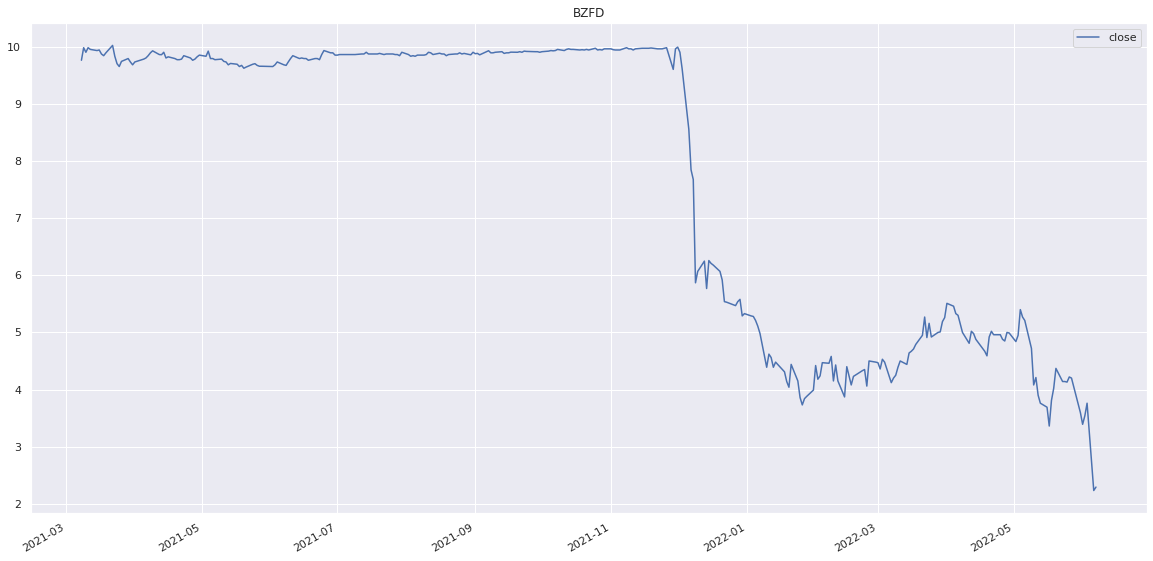

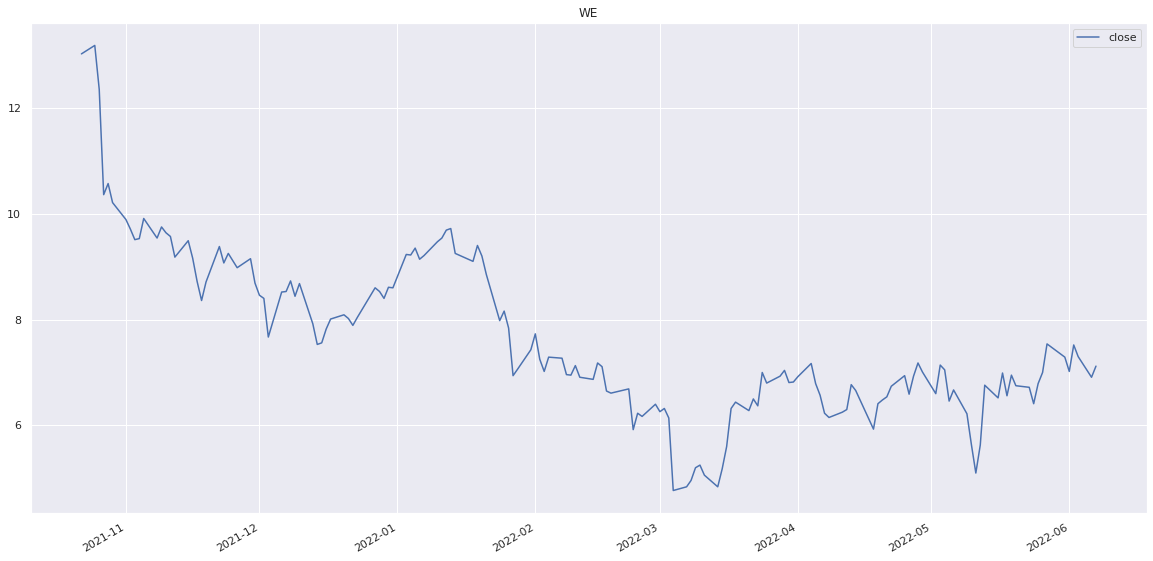

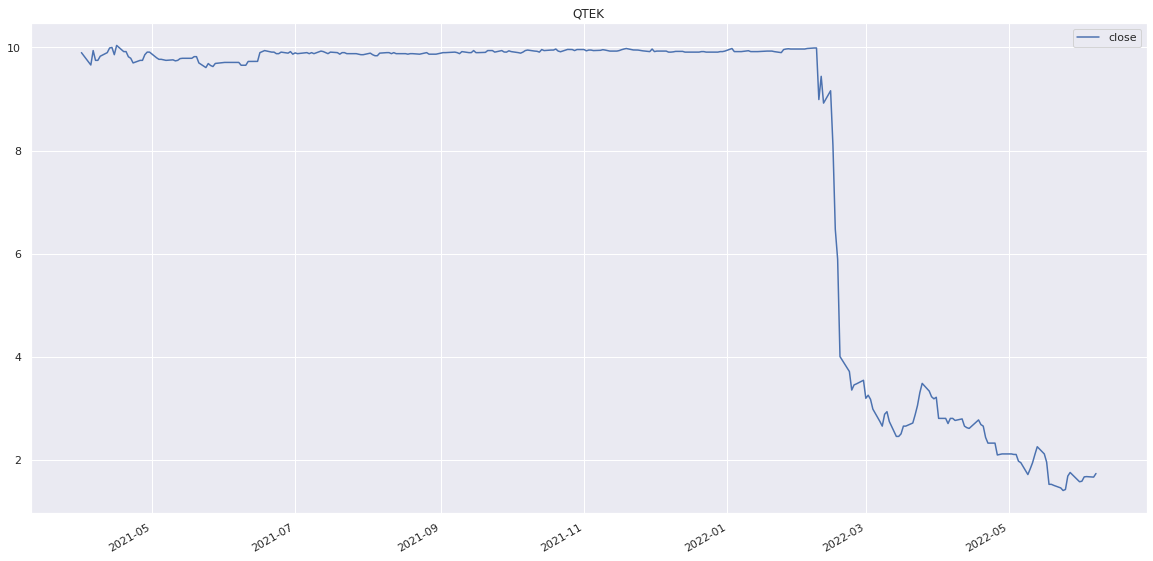

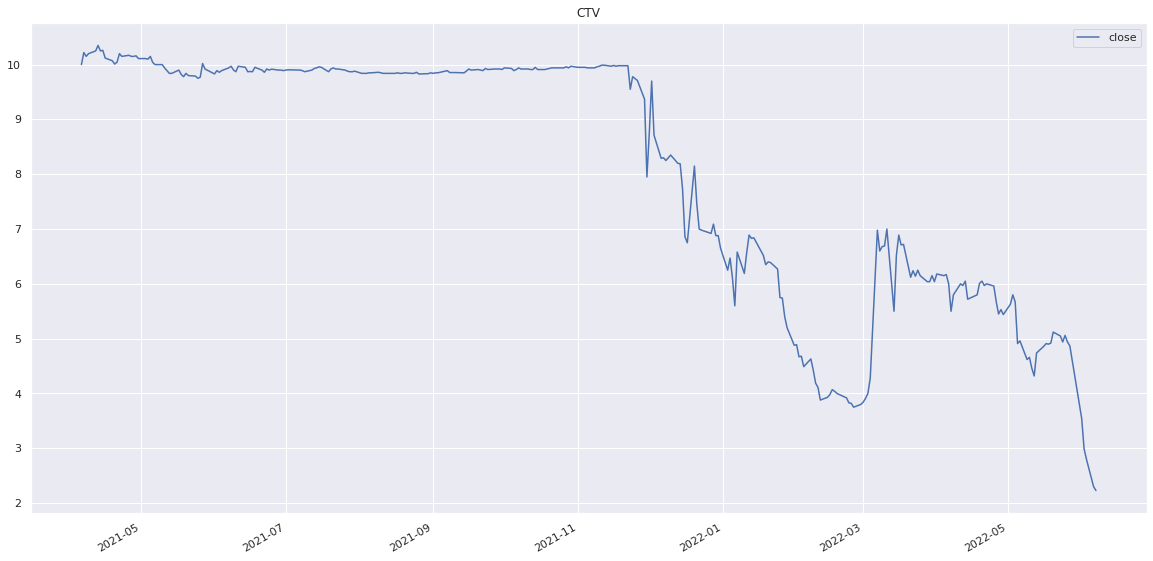

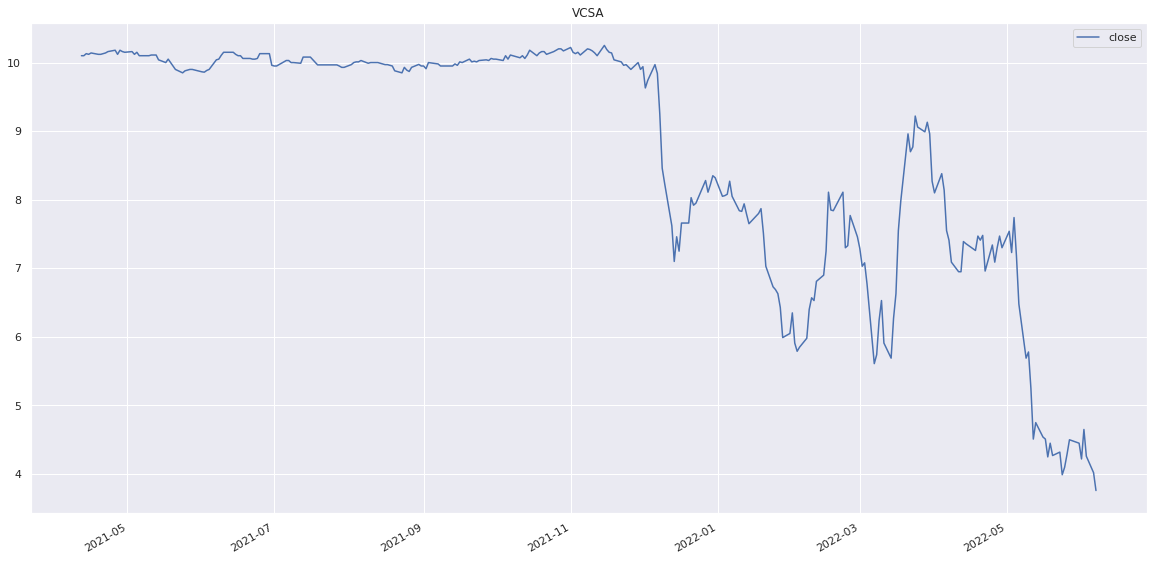

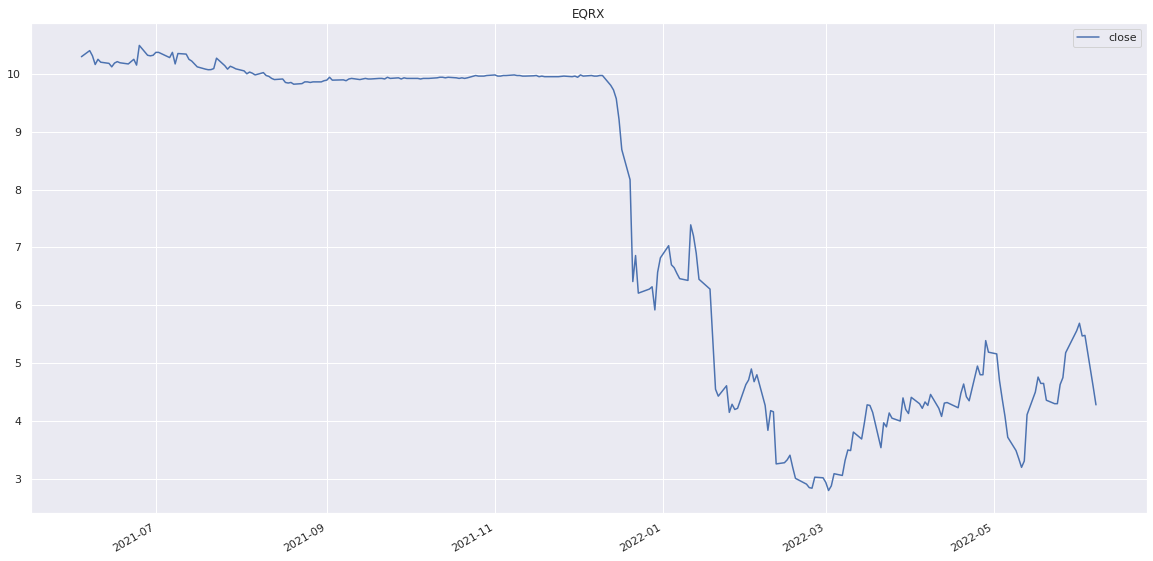

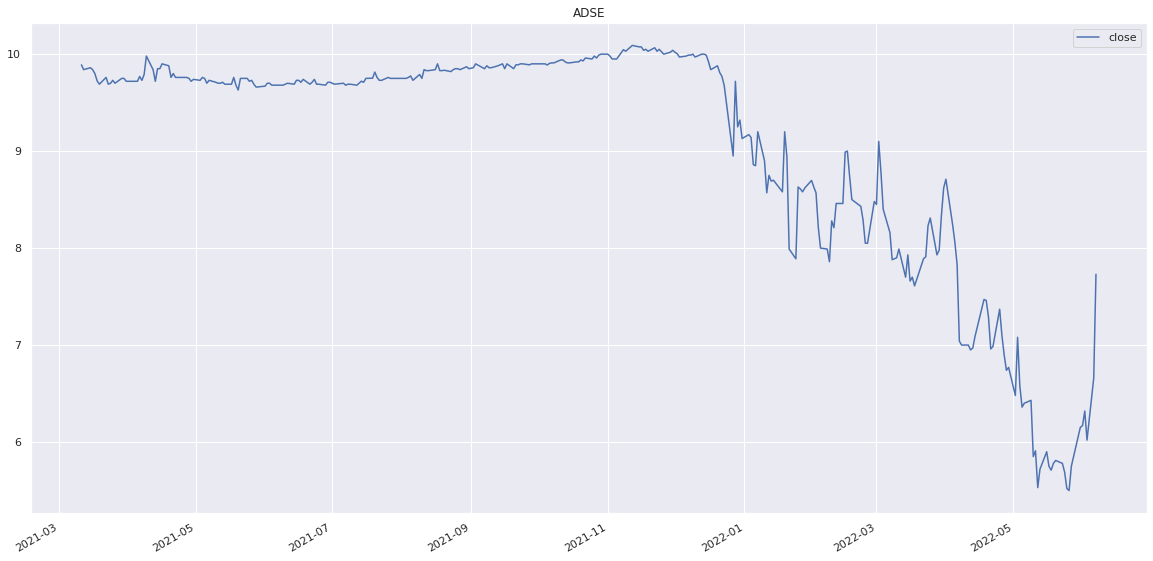

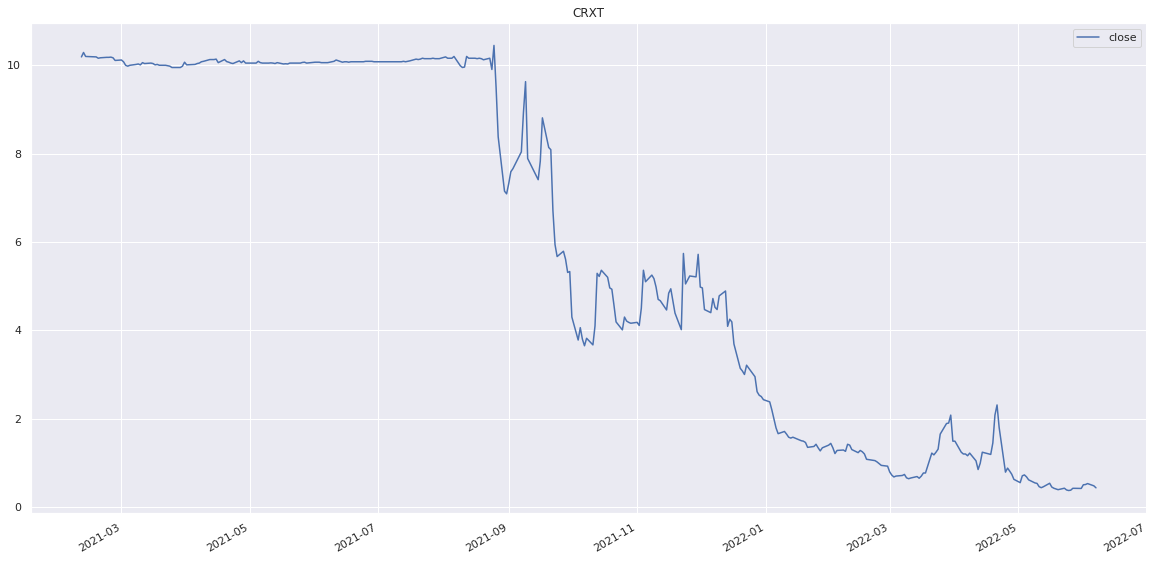

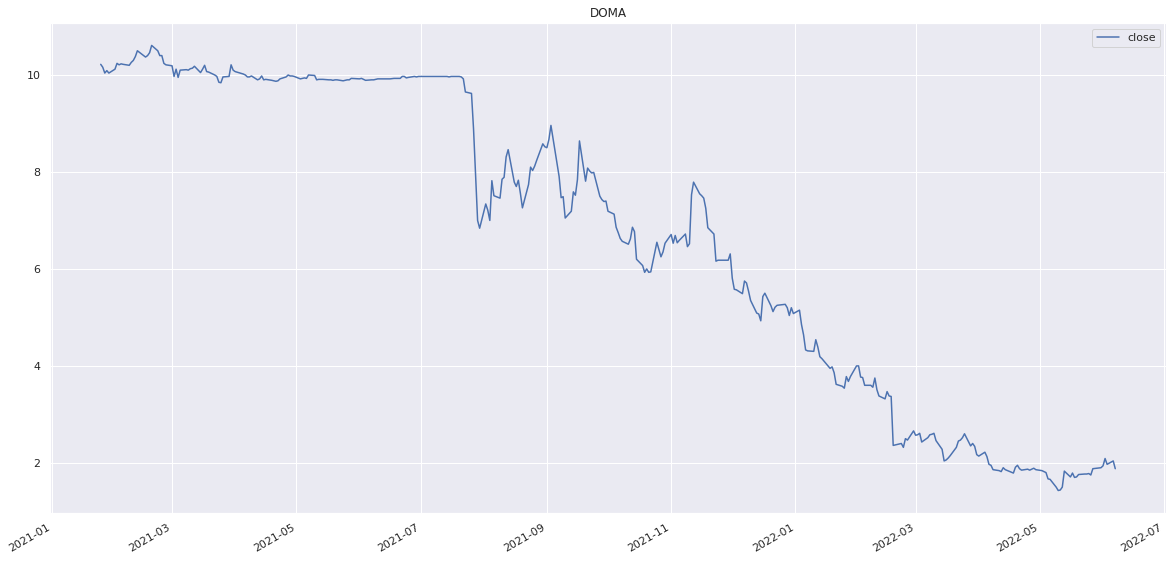

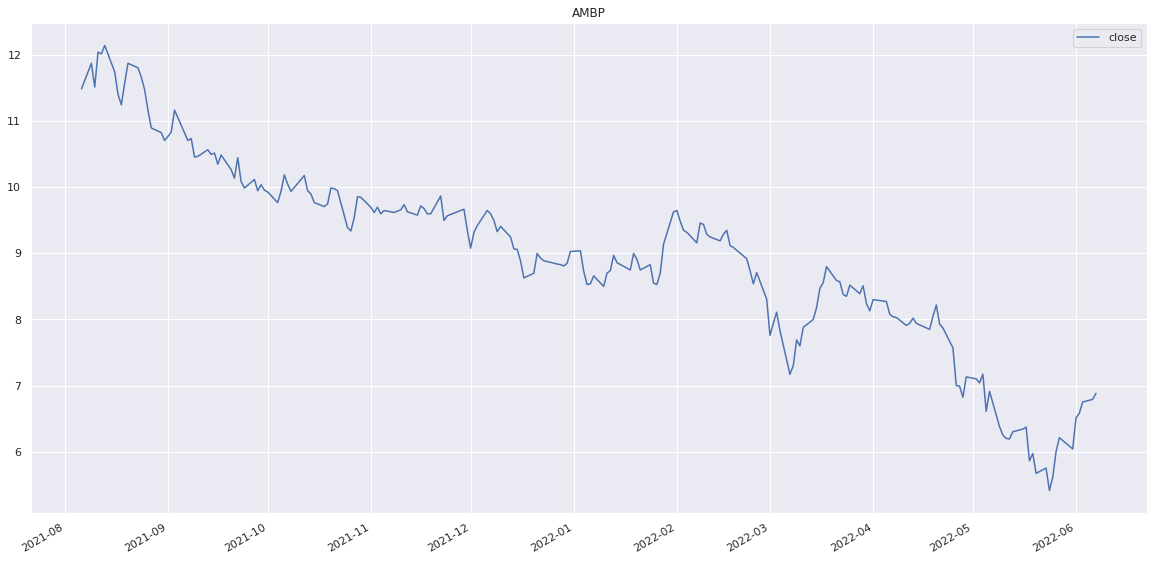

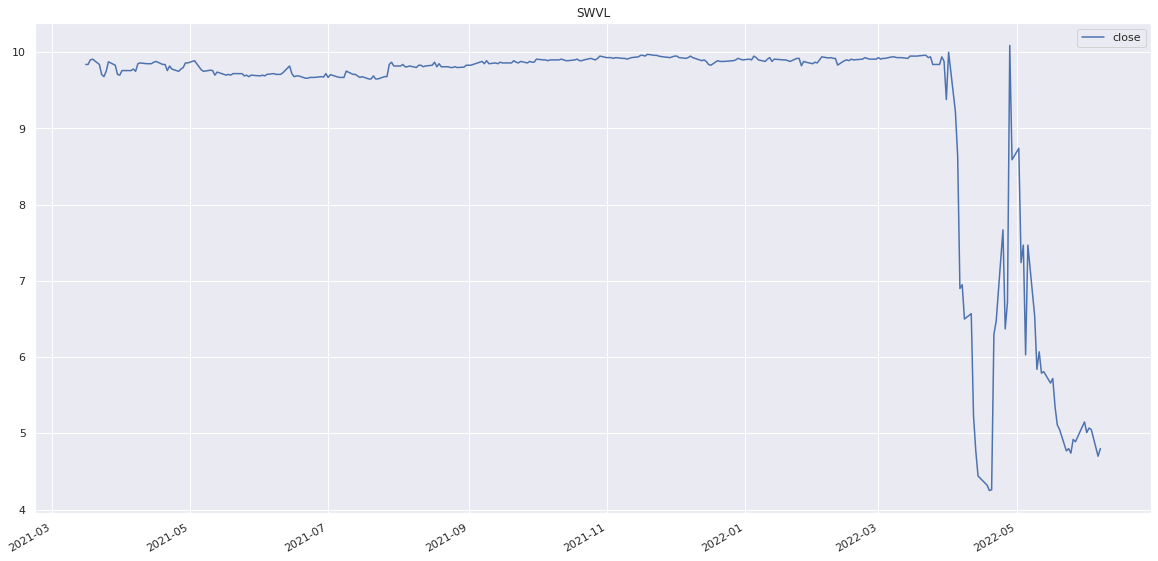

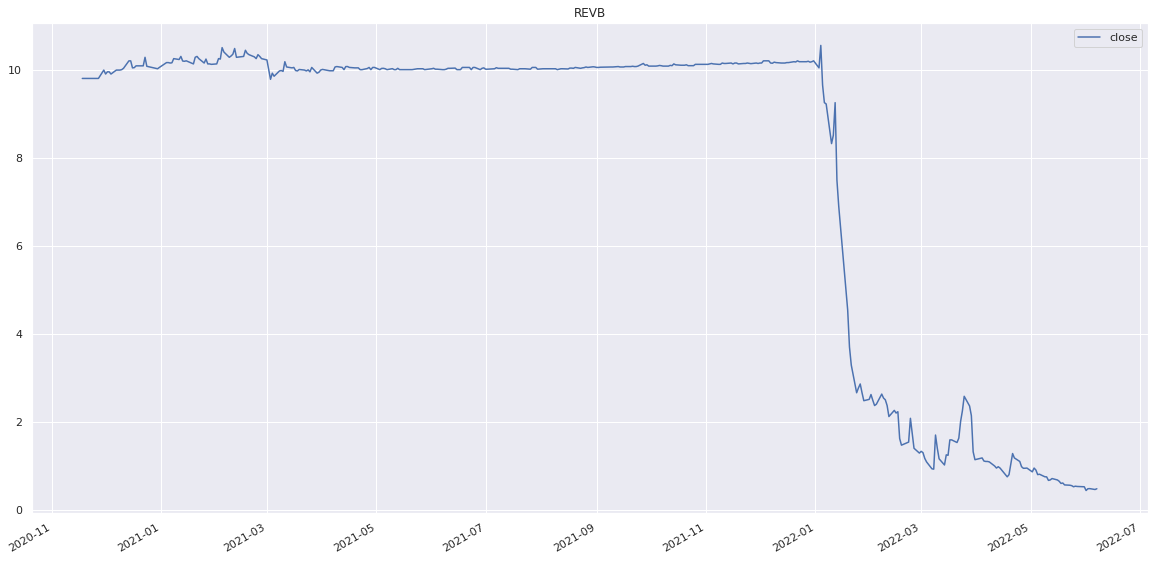

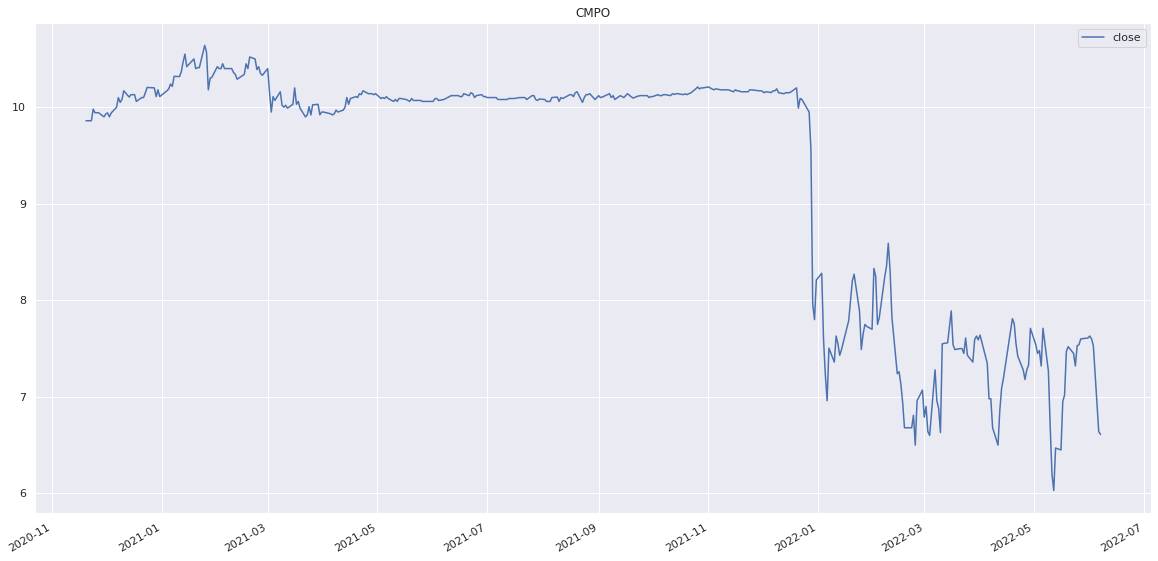

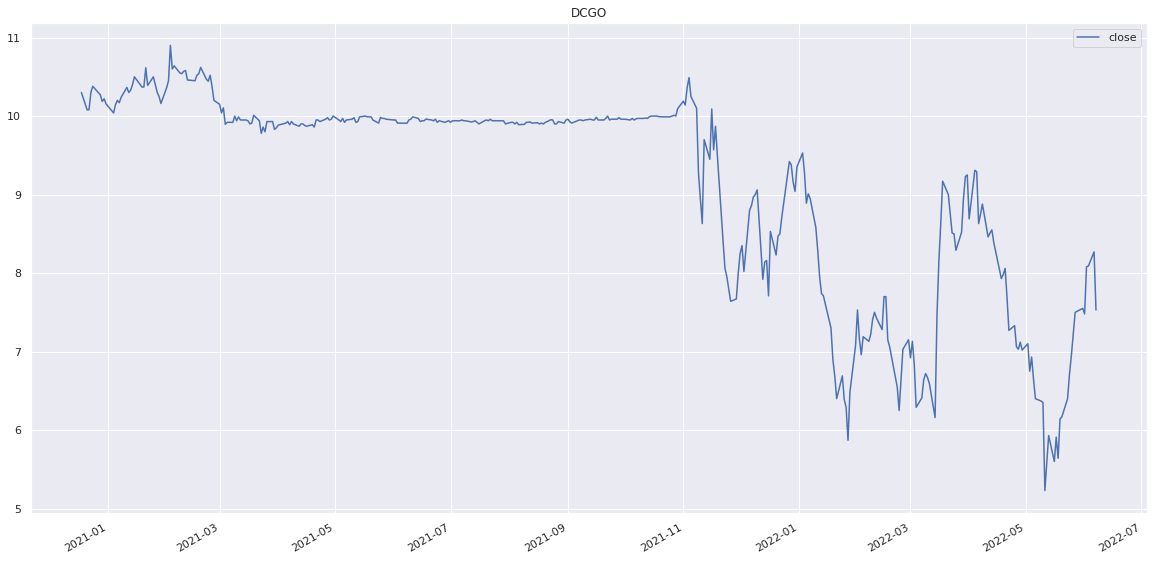

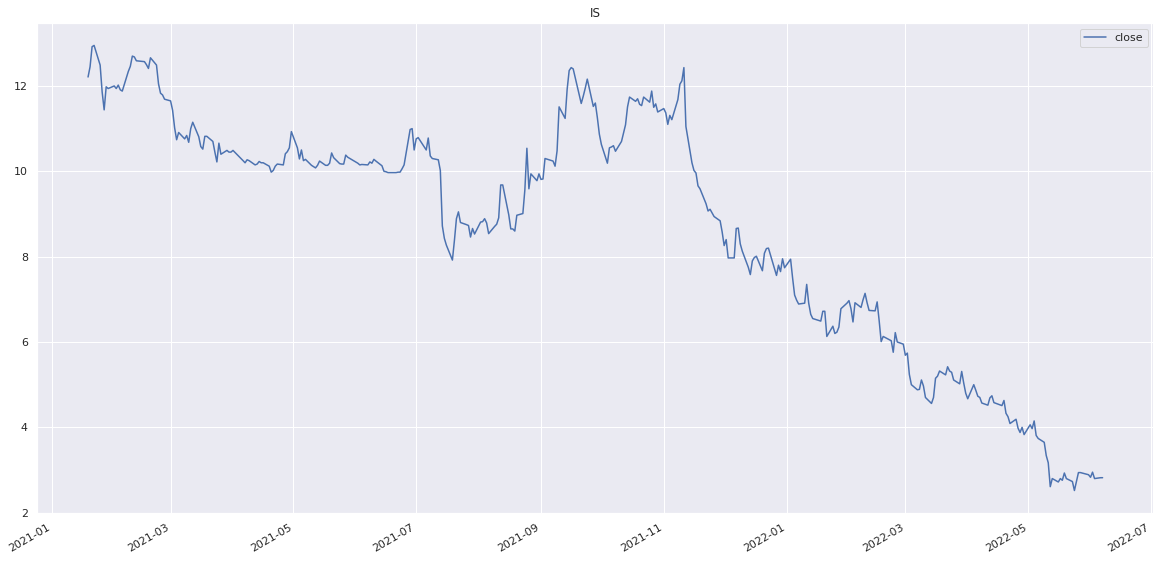

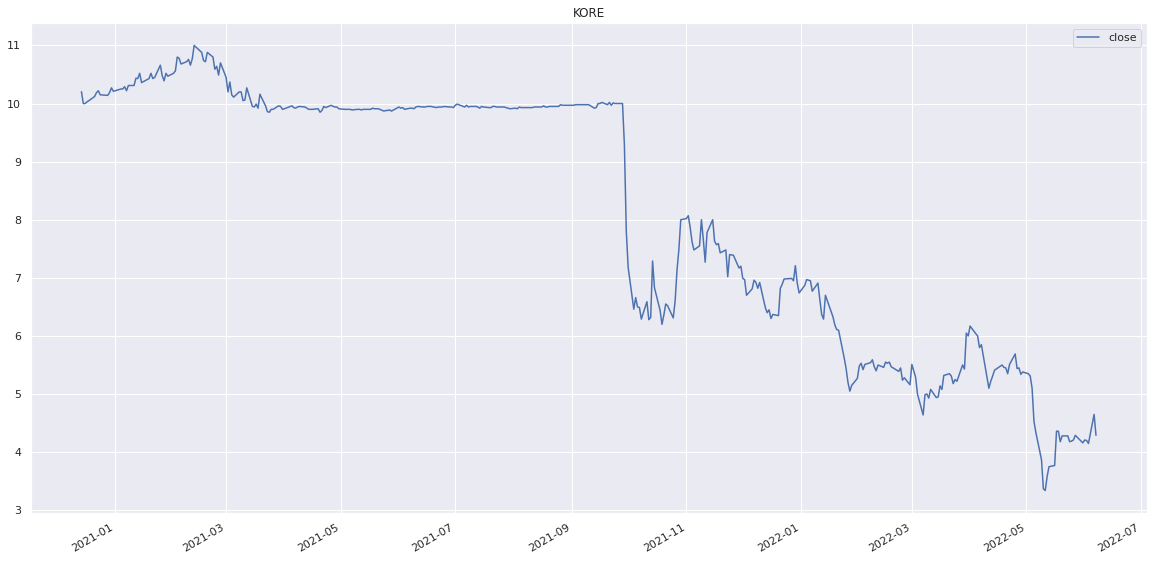

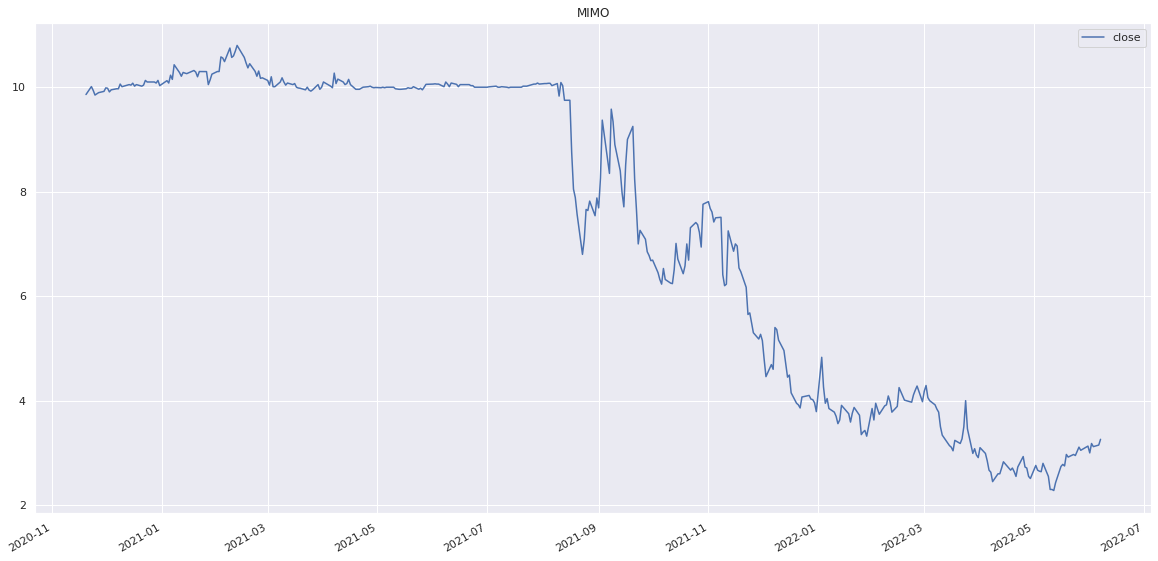

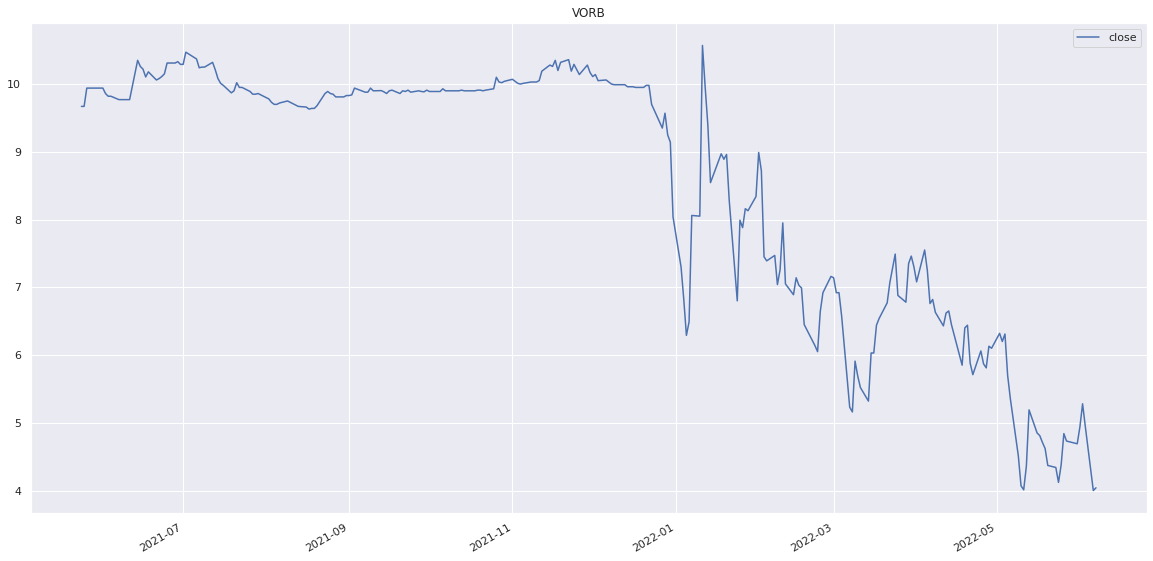

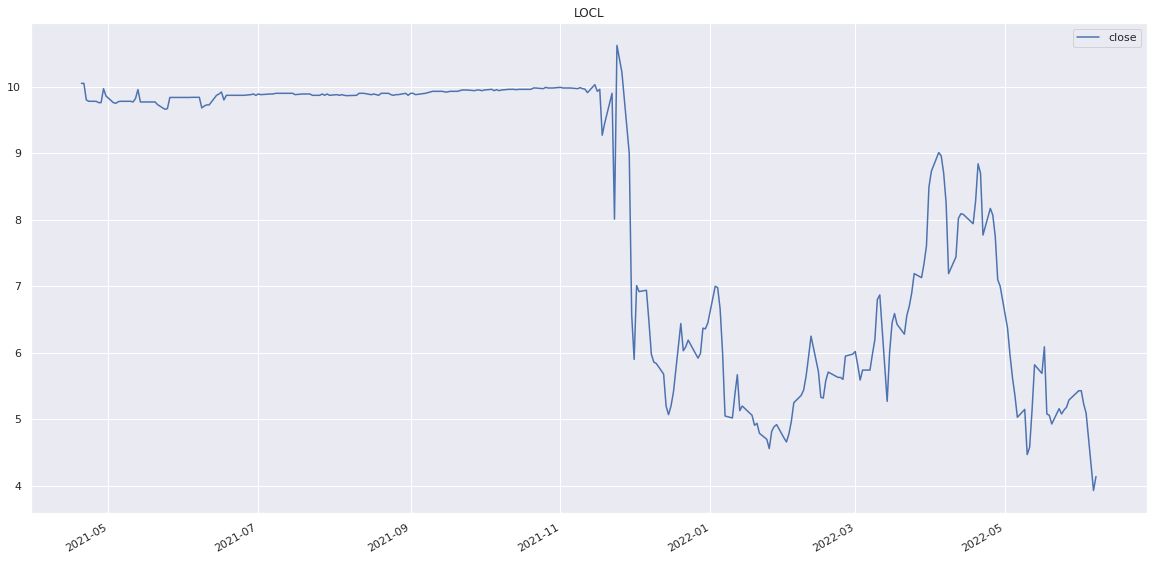

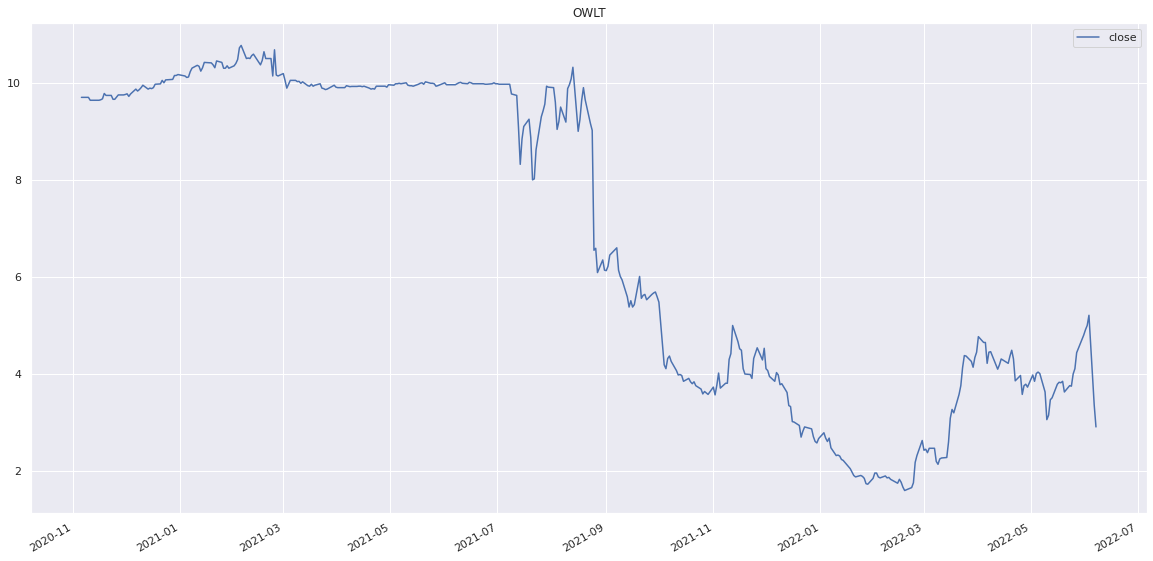

In [178]:
for x in bottom.symbol.values[:20]:
  ax = dfs[x]['data'][['close']].plot()
  ax.set_title(x)

Those are the SPACs we would like to avoid, now let's take a look at the most profitable ones.
Again, from looking at the top 20 we can see some similarity but we still do not know whether this behavior is predictable or not

In [199]:
top = df.loc[(df['potential_investment_return'] > 50) & (df['dataset_size_before_peak'] > 60) & (df['dataset_size_after_peak'] > 60) & (df['max_price_date'] > '2018')].sort_values('potential_investment_return', ascending=False)
top

,max_price_date,max_price,min_price,min_price_date,average_price_before_peak,first_date,dataset_size,potential_investment_return,symbol,dataset_size_before_peak,dataset_size_after_peak
250,2019-02-01,308.399994,0.542,2020-04-03,13.512778,2016-10-31,1410,1527.598883,PHUN,567,844
11,2022-02-17,92.650002,4.840,2022-05-24,10.064430,2021-02-10,334,574.398174,ISPO,259,76
240,2020-06-09,79.730003,5.090,2022-05-11,10.840868,2018-06-12,1005,444.820421,NKLA,502,504
255,2020-12-22,131.669998,9.793,2020-08-21,22.492736,2020-08-18,455,339.772294,QS,89,367
153,2021-02-02,62.709999,0.535,2022-05-27,11.156516,2017-12-05,1134,323.465131,NRXP,795,340
...,...,...,...,...,...,...,...,...,...,...,...
155,2021-02-16,18.600000,5.600,2022-05-11,10.379841,2019-11-06,651,55.435454,BLDE,321,331
57,2021-11-04,17.930000,1.680,2022-02-25,10.114424,2020-12-11,374,54.090112,RDBX,227,148
183,2021-02-16,19.330000,4.230,2022-05-12,10.962703,2019-08-07,715,53.427587,BTRS,385,331
56,2021-11-19,17.110001,2.900,2022-05-25,9.906677,2021-05-11,272,50.898266,AUR,136,137


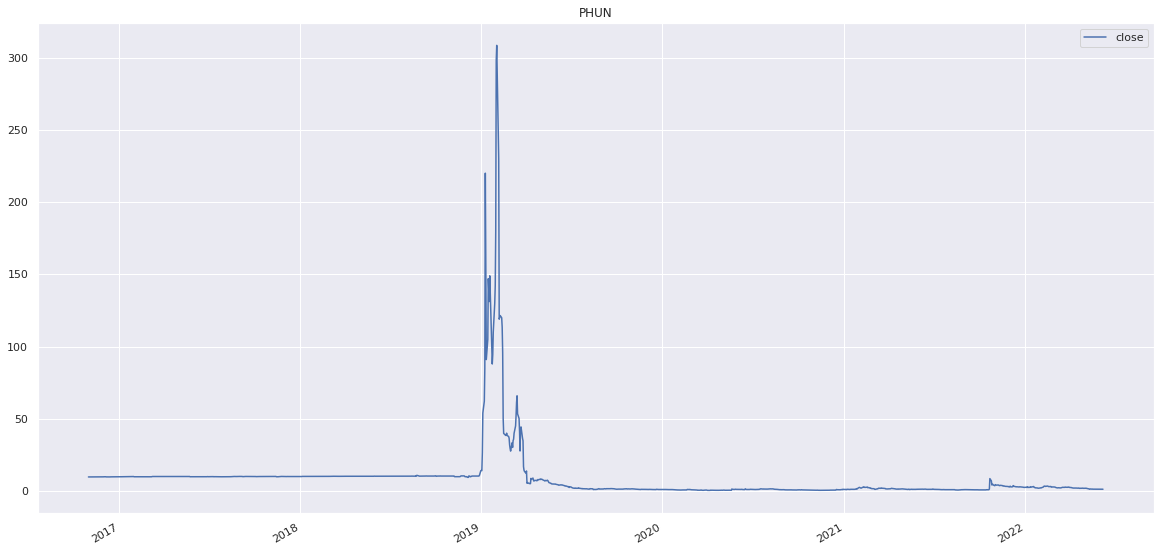

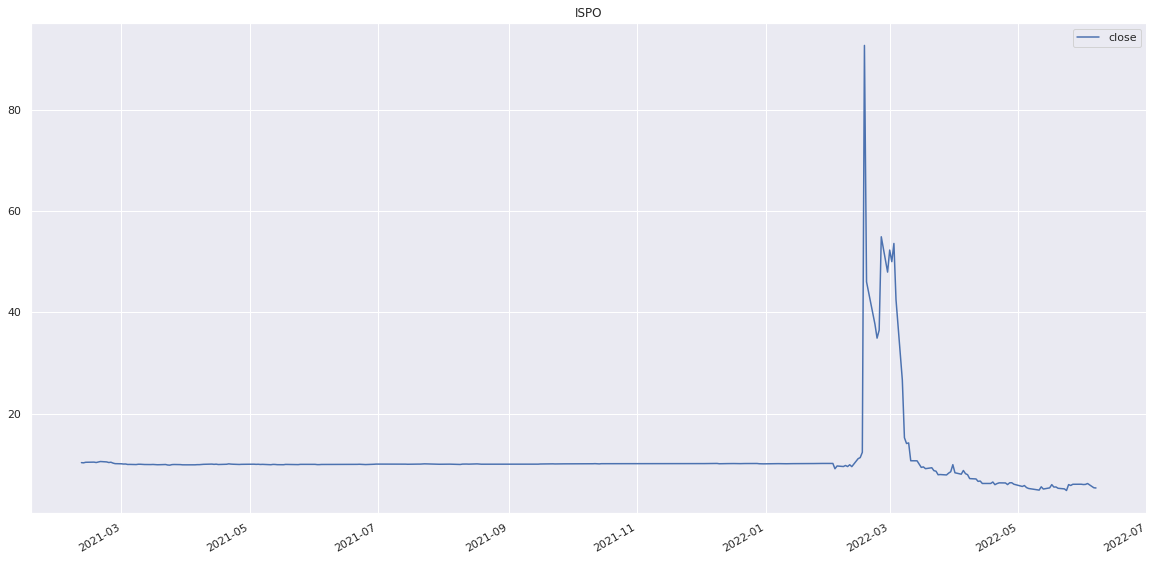

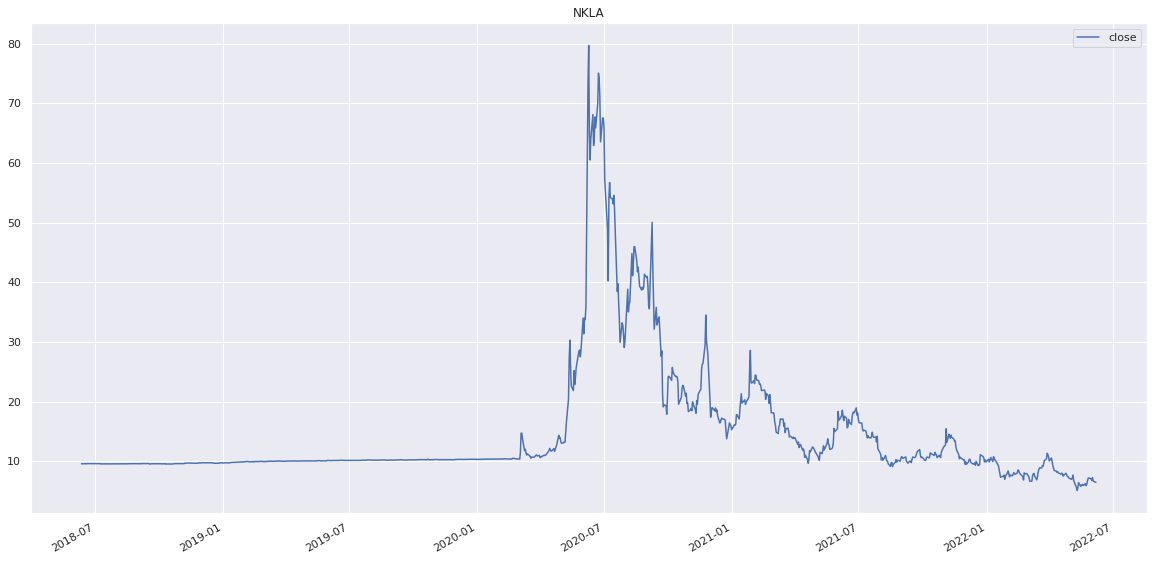

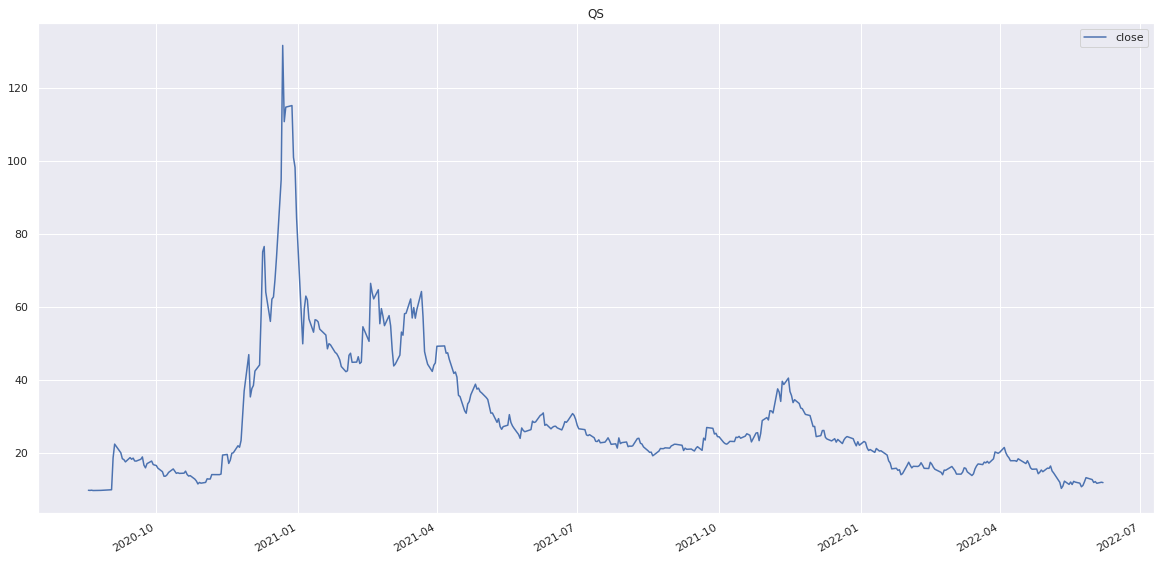

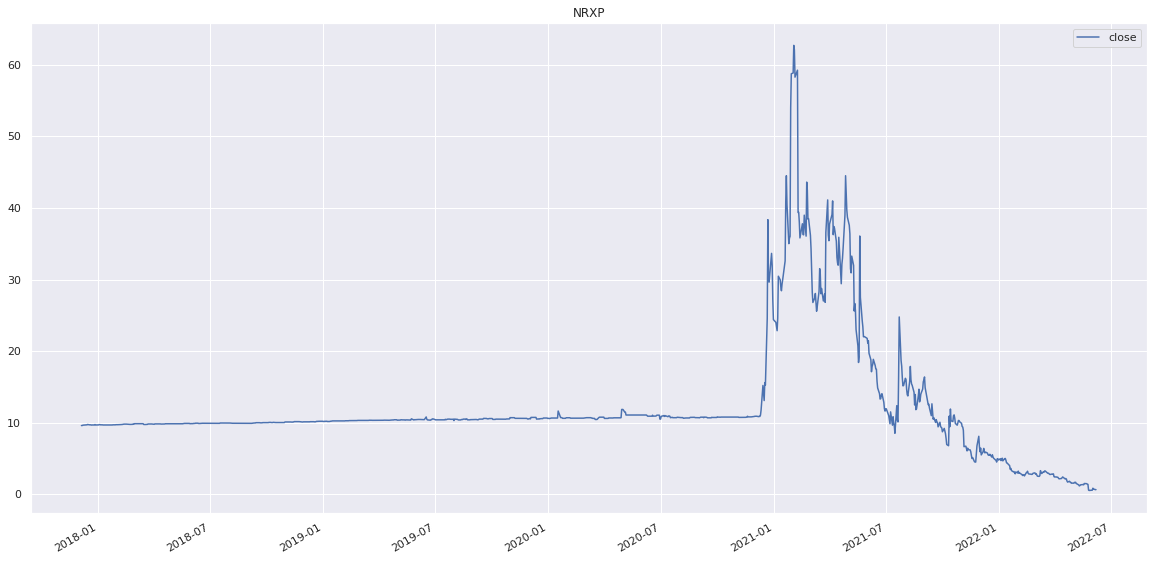

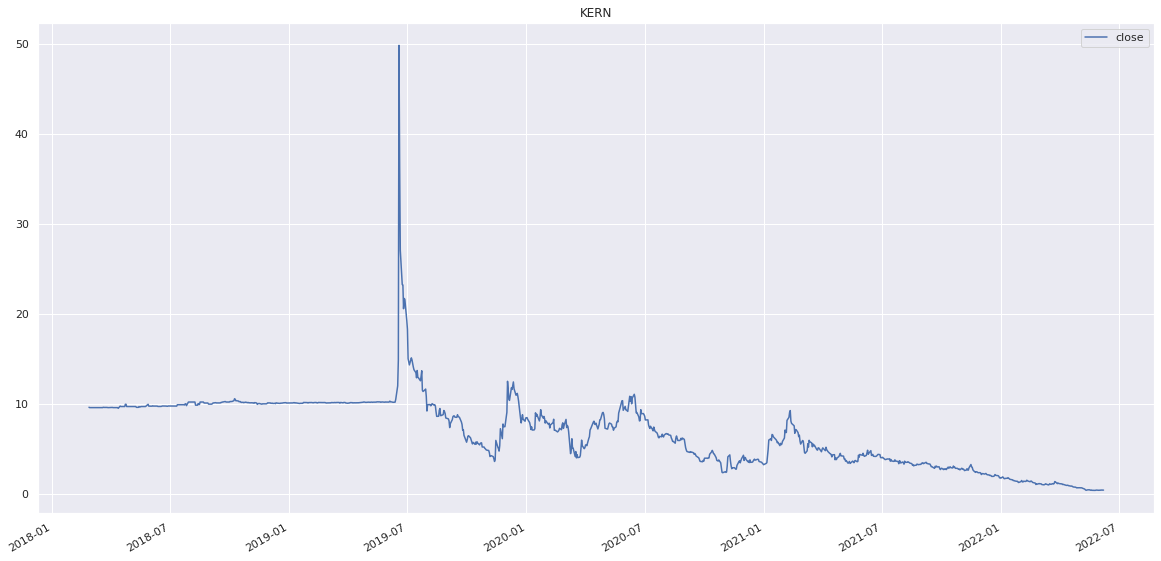

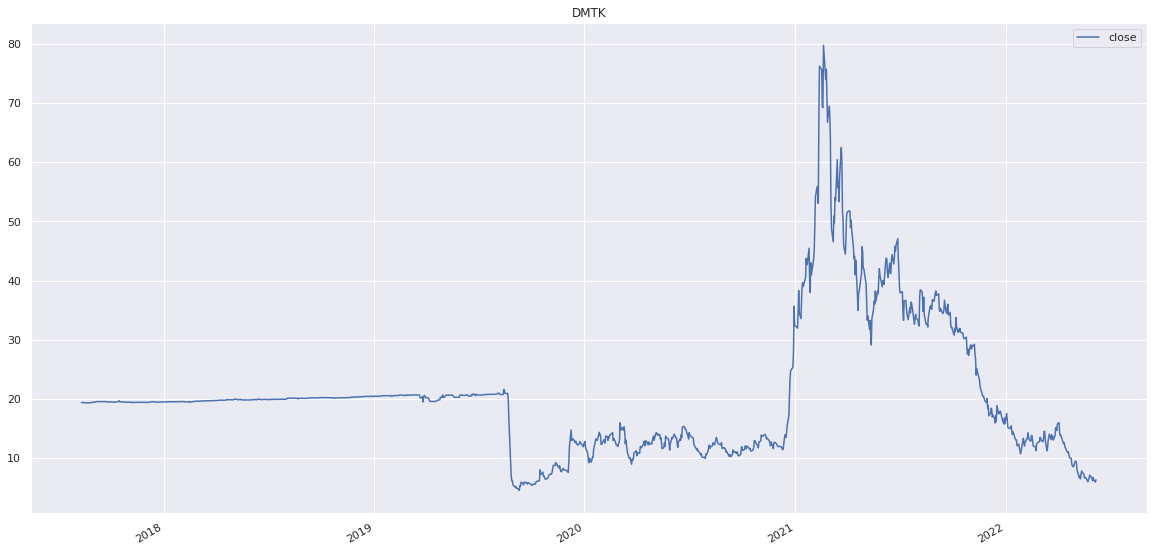

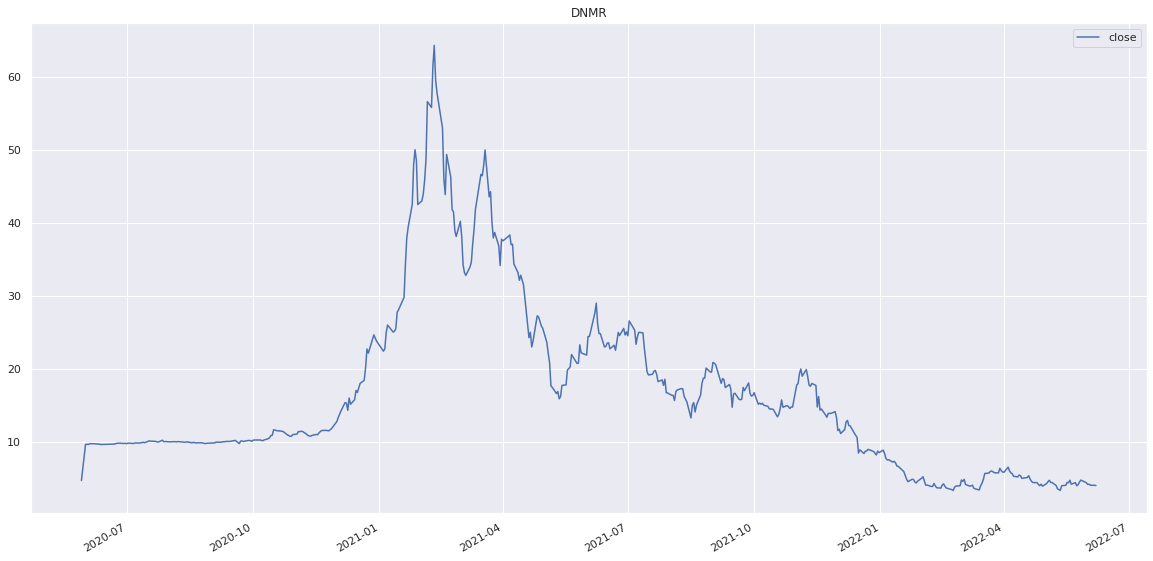

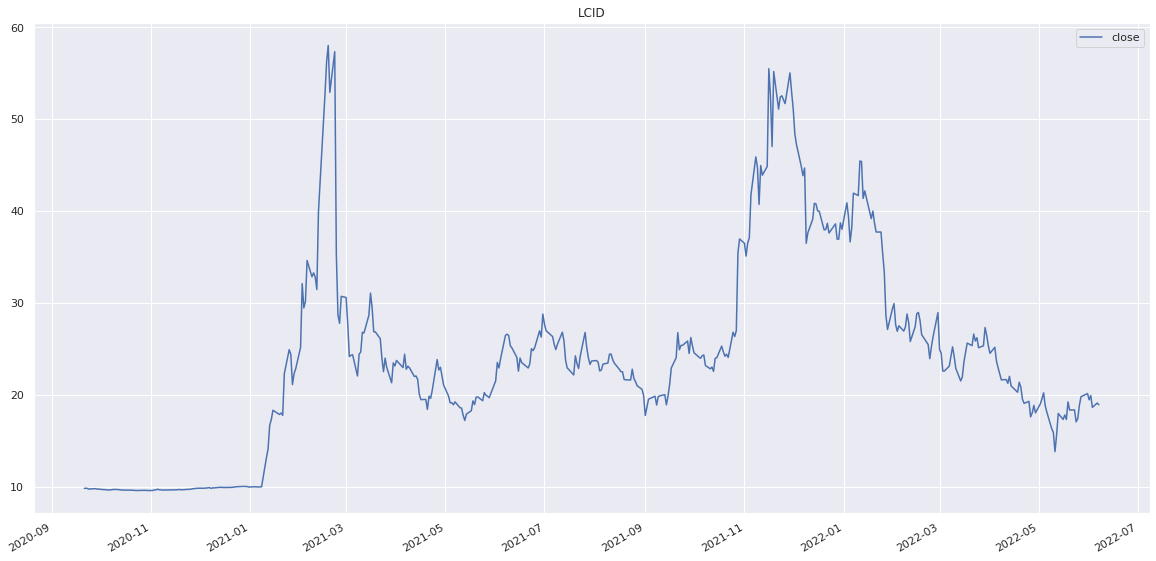

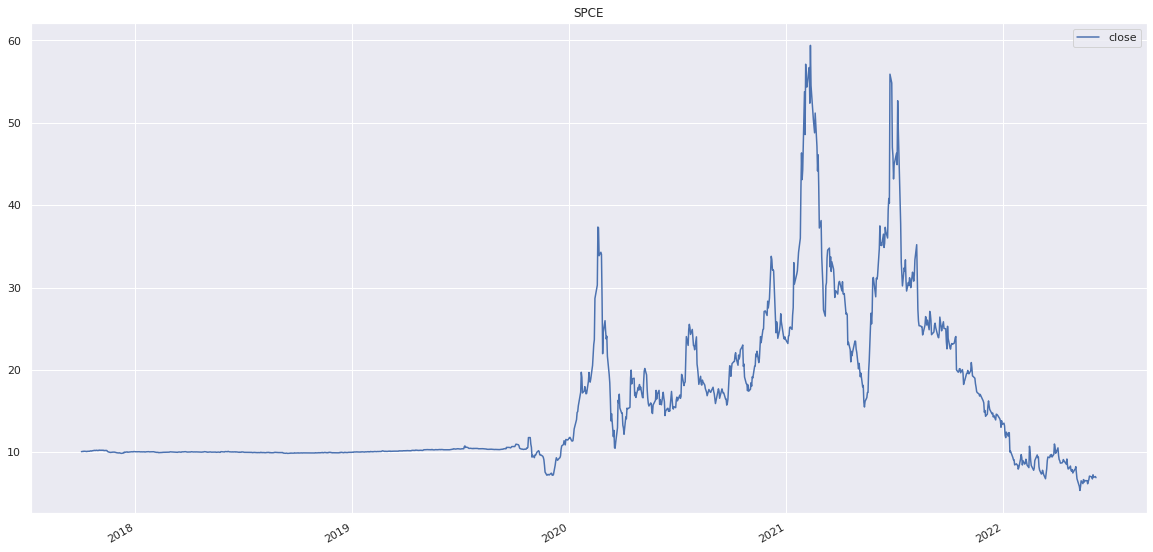

In [177]:
for x in top.symbol.values[:20]:
  ax = dfs[x]['data'][['close']].plot()
  ax.set_title(x)

If we look at the distribution of the price peaks over time for the whole population and the top most profitable SPAC's we see that most of the activity took place between 2021 and 2022 with high concentration at the beggining of 2021 which is suspicious because those years were realy unique from the economic environment and market behavior perspective due to COVID-19 implications.

However we can also assume the trend of IPO using SPAC merge is an increasing trend that will become more popular in the future (there are still 600+ SPACs pending to be merged)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


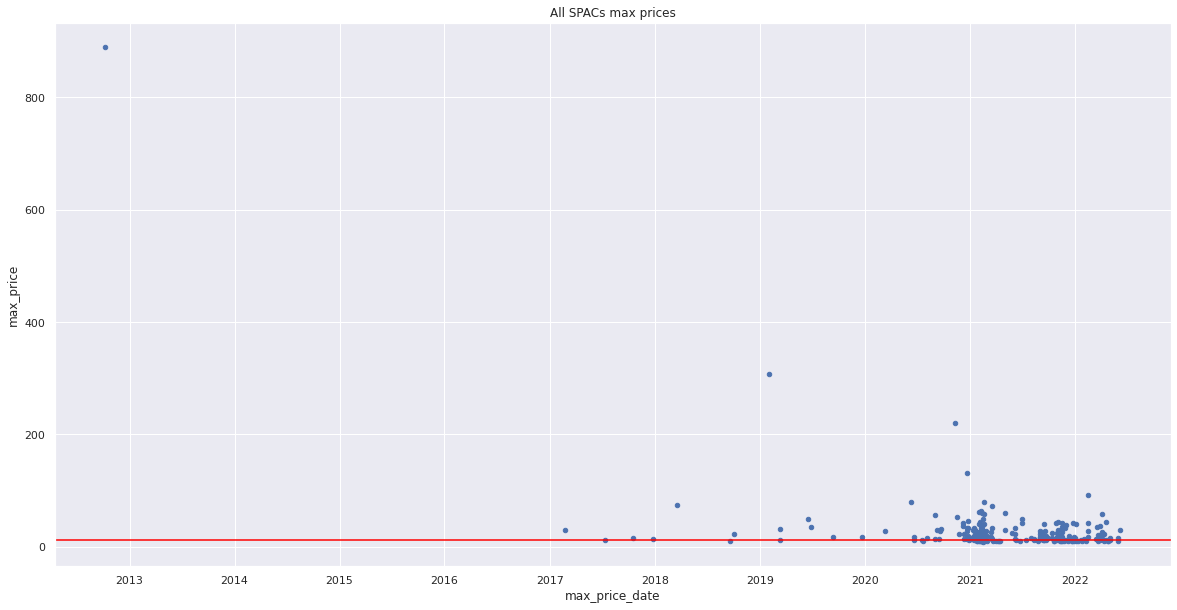

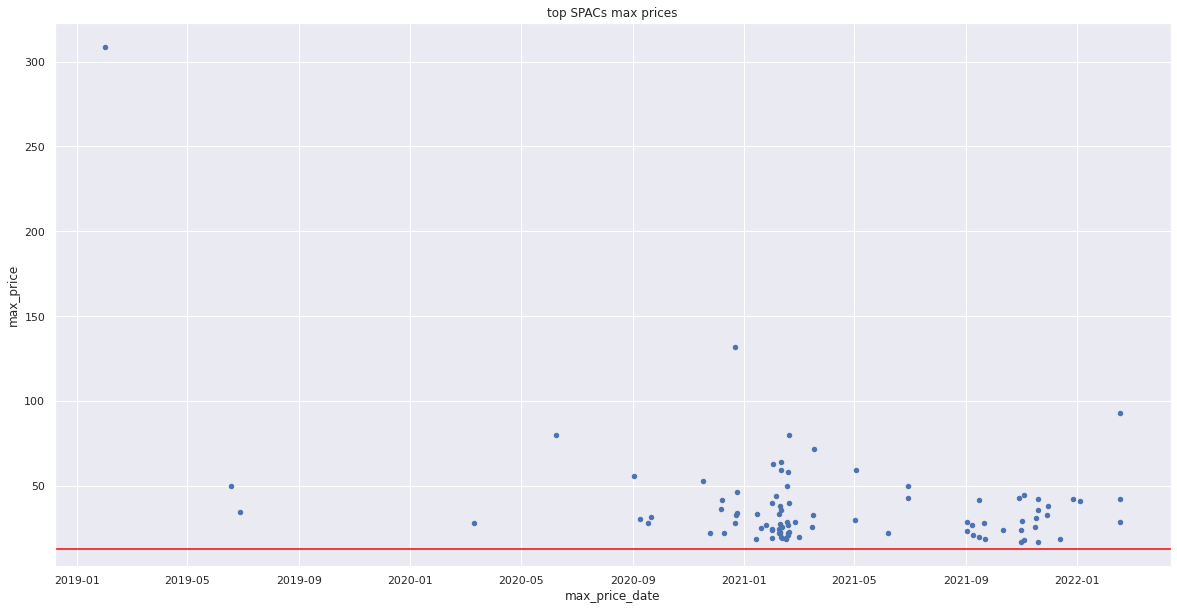

In [202]:
df[['max_price_date', 'max_price']].plot(y='max_price', x='max_price_date', kind='scatter').set_title('All SPACs max prices')
plt.axhline(y=df.average_price_before_peak.mean(), color='red')
top[['max_price_date', 'max_price']].plot(y='max_price', x='max_price_date', kind='scatter').set_title('top SPACs max prices')
plt.axhline(y=top.average_price_before_peak.mean(), color='red')


looking at the potential returns both for the least profitable and most profitable SPACS the average return is above 7% which is the average return of the SP500 index which means predicting it's behavior is still profitable enough
(Even if we are not able to avoid the least profitable ones)

In [170]:
print("Average return % on investment in top leading SPACS: ", top['potential_investment_return'].mean())
print("Average return % on investment in least profitable SPACS: ", bottom['potential_investment_return'].mean())

Average return % on investment in SPACS:  75.98259451383666
Average return % on investment in top leading SPACS:  143.2958790735843
Average return % on investment in least profitable SPACS:  21.064717046929026


trying to predict the price with prophet which is a time series anlysis tool we got poor results since there is no seasonality in the data and model can't be trained on multiple stocks.

bellow are the predictions for the 10 most profitable and 10 least profitable SPACs

22:14:56 - cmdstanpy - INFO - Chain [1] start processing
22:14:56 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

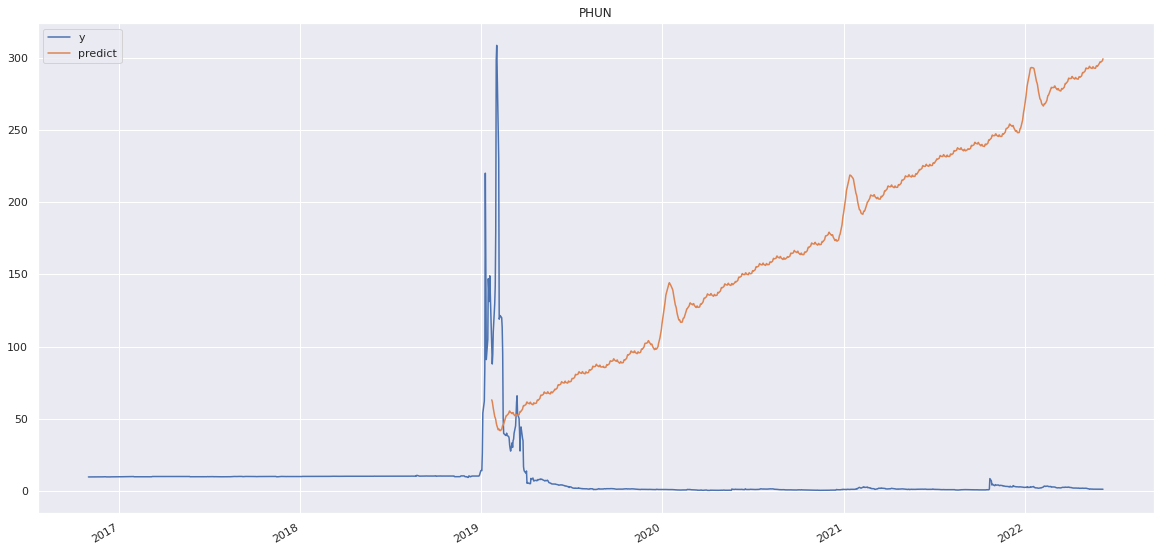

22:15:01 - cmdstanpy - INFO - Chain [1] start processing
22:15:01 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

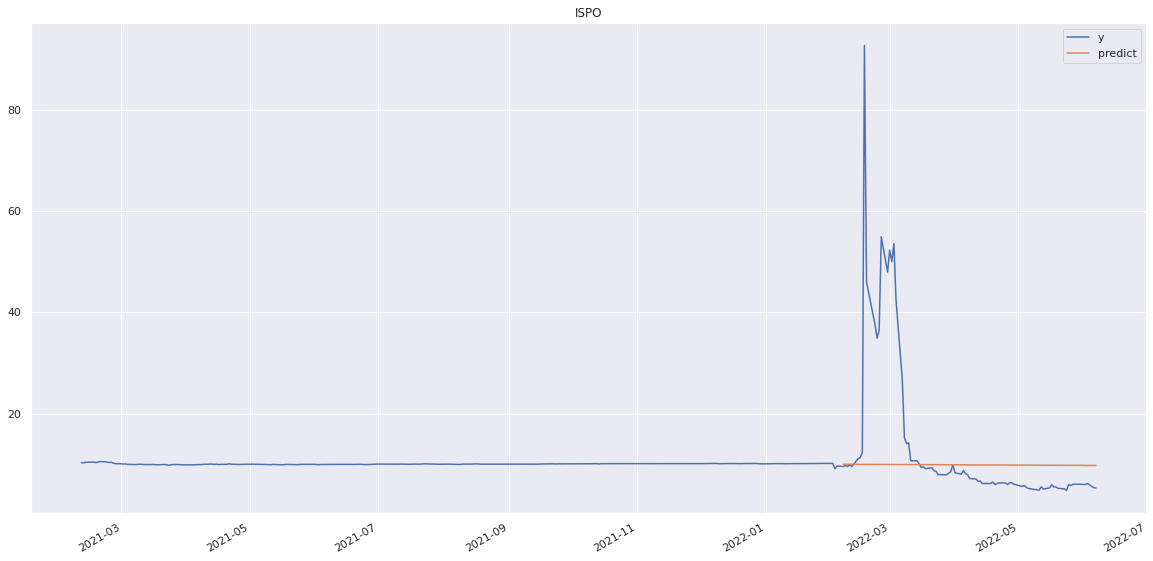

22:15:03 - cmdstanpy - INFO - Chain [1] start processing
22:15:03 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

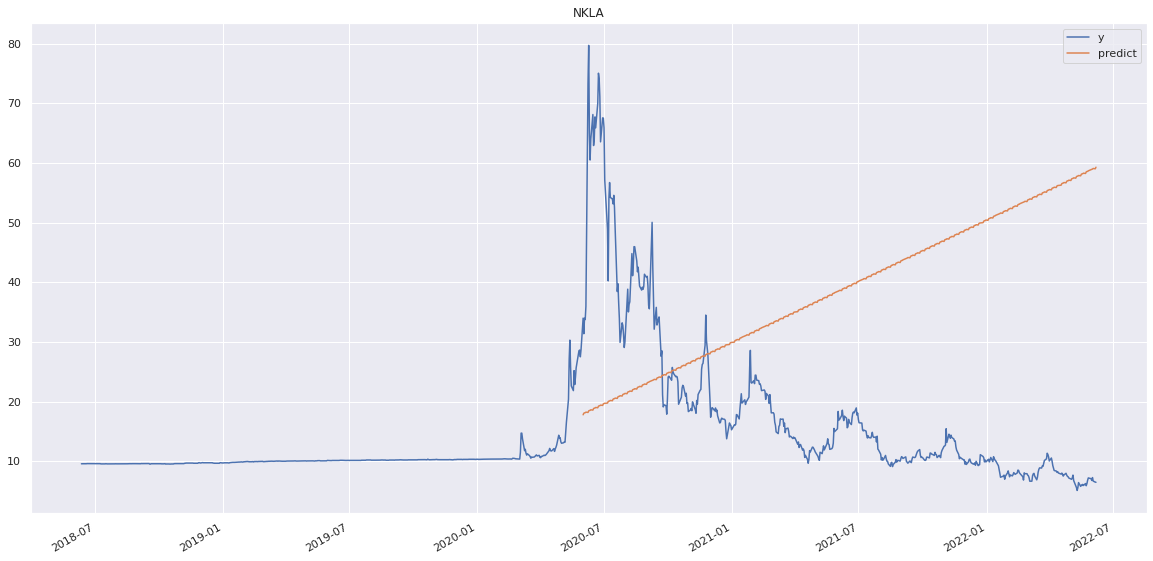

22:15:06 - cmdstanpy - INFO - Chain [1] start processing
22:15:07 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

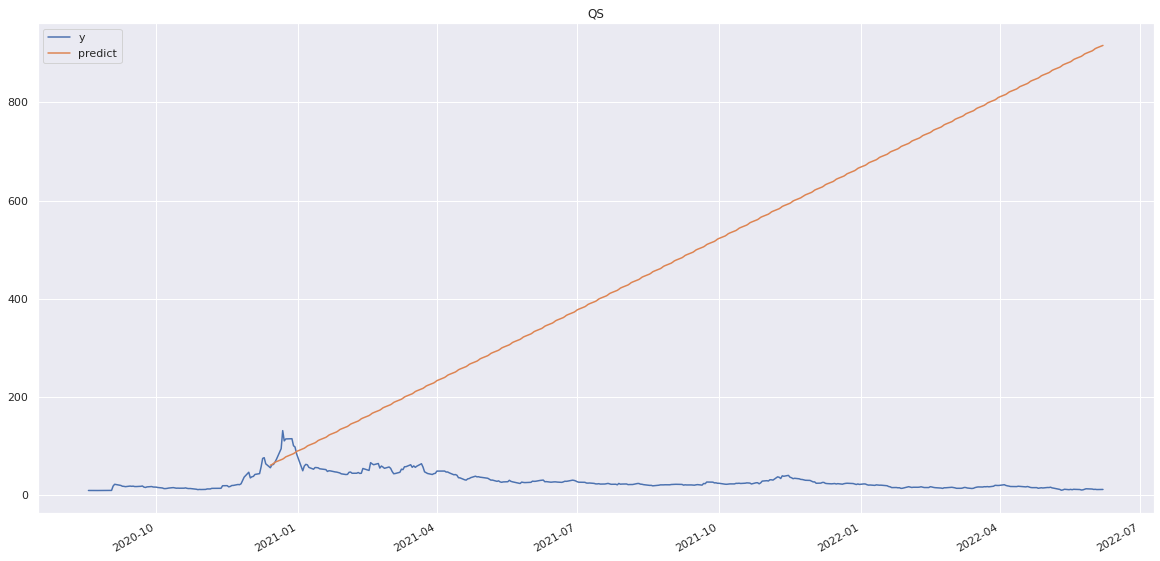

22:15:10 - cmdstanpy - INFO - Chain [1] start processing
22:15:10 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

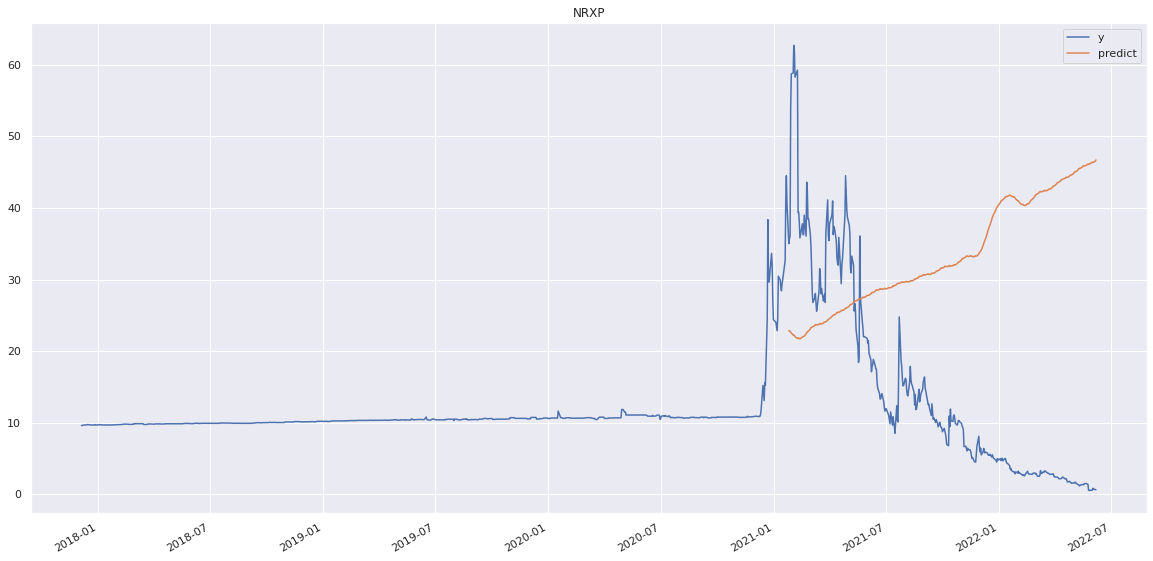

22:15:13 - cmdstanpy - INFO - Chain [1] start processing
22:15:13 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

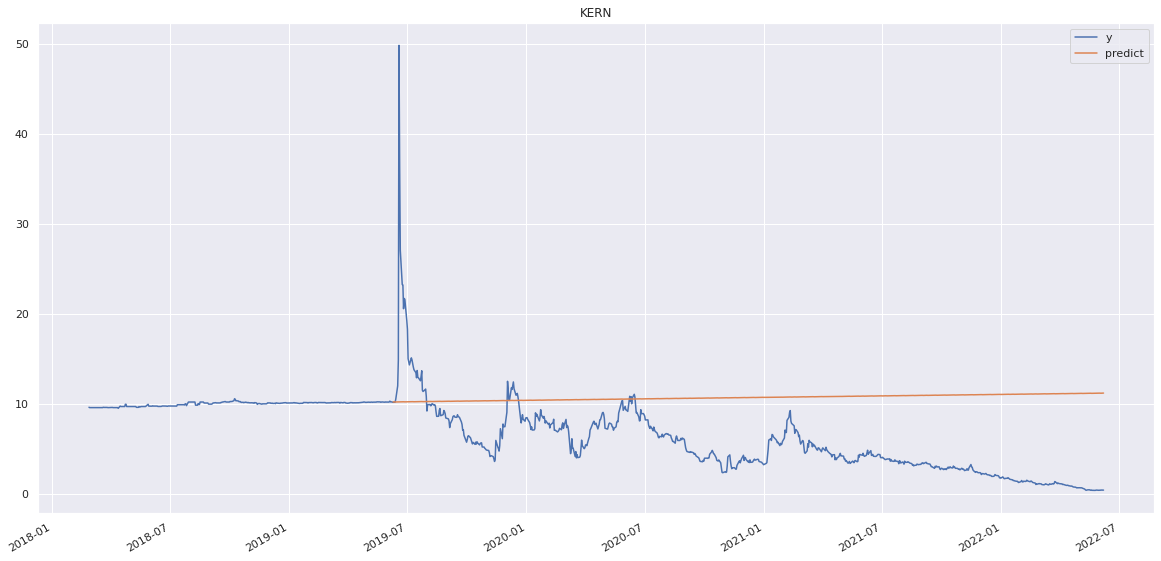

22:15:16 - cmdstanpy - INFO - Chain [1] start processing
22:15:17 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

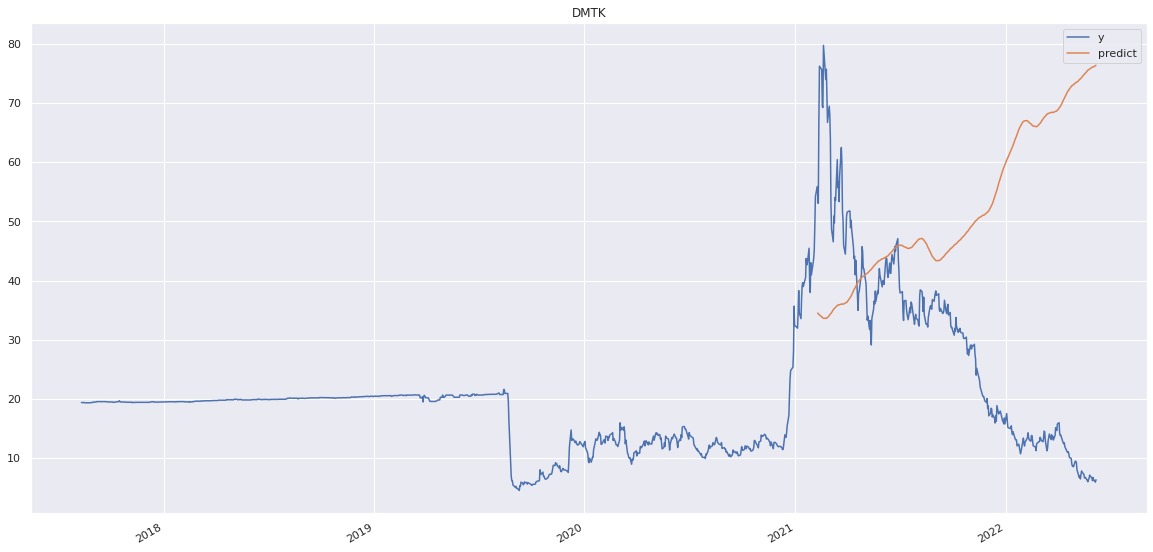

22:15:19 - cmdstanpy - INFO - Chain [1] start processing
22:15:19 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

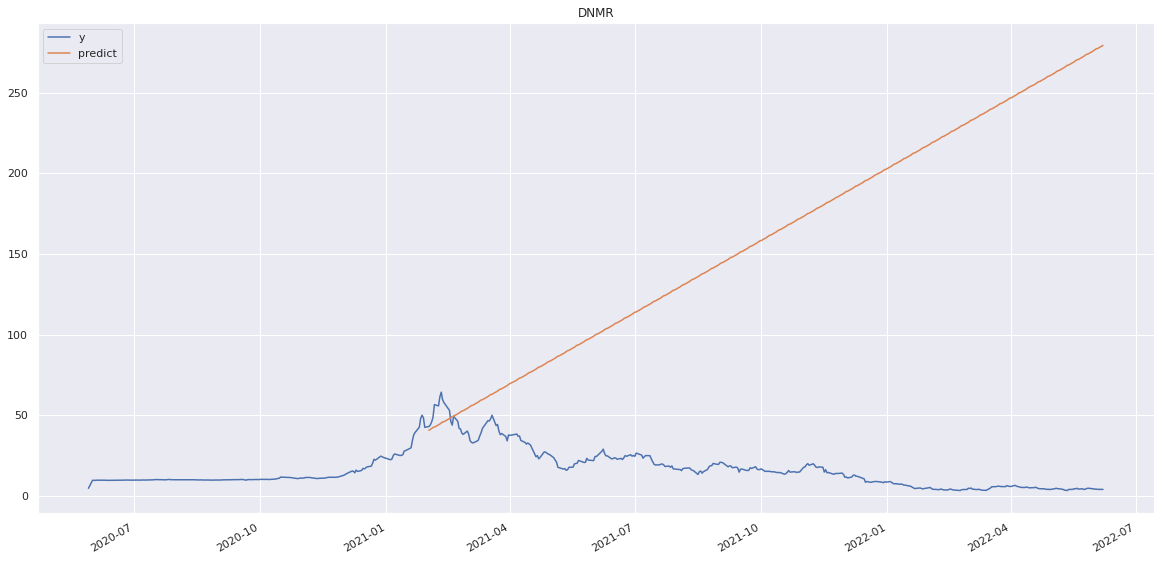

22:15:22 - cmdstanpy - INFO - Chain [1] start processing
22:15:23 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

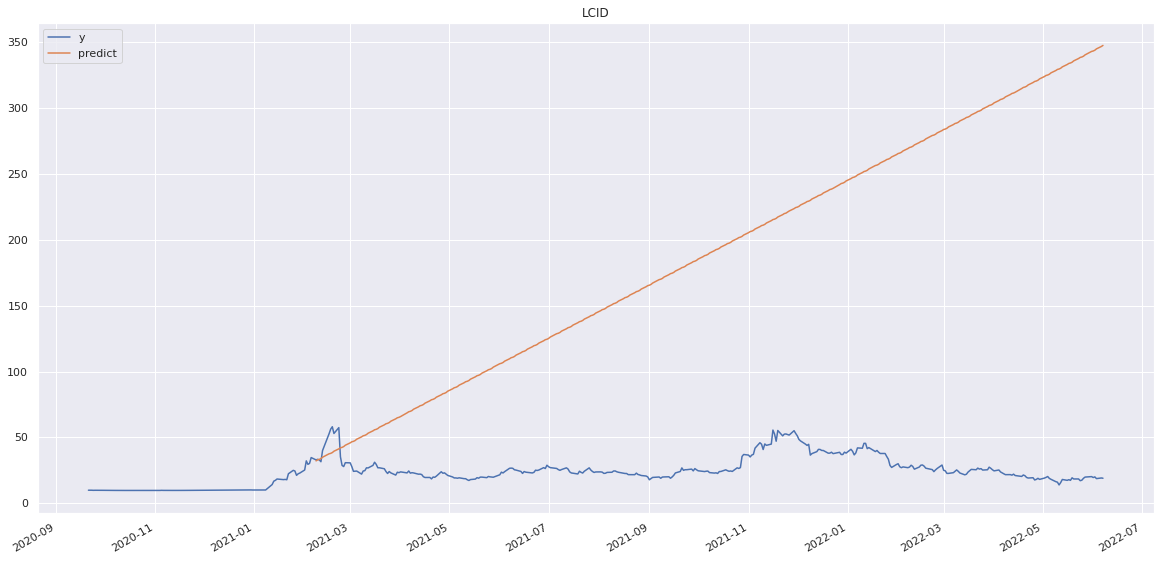

22:15:26 - cmdstanpy - INFO - Chain [1] start processing
22:15:26 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

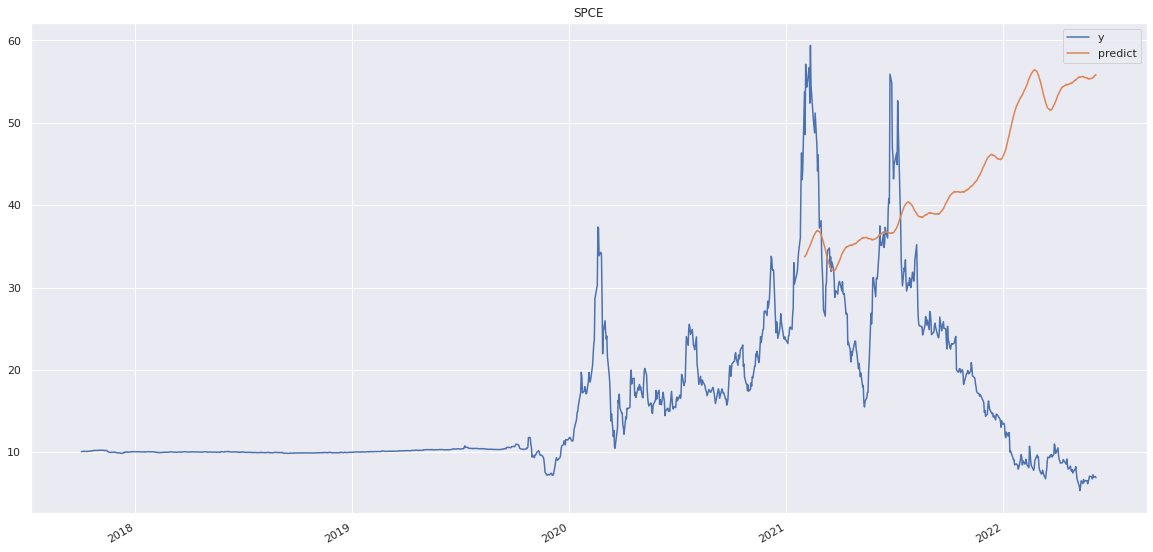

22:15:29 - cmdstanpy - INFO - Chain [1] start processing
22:15:31 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

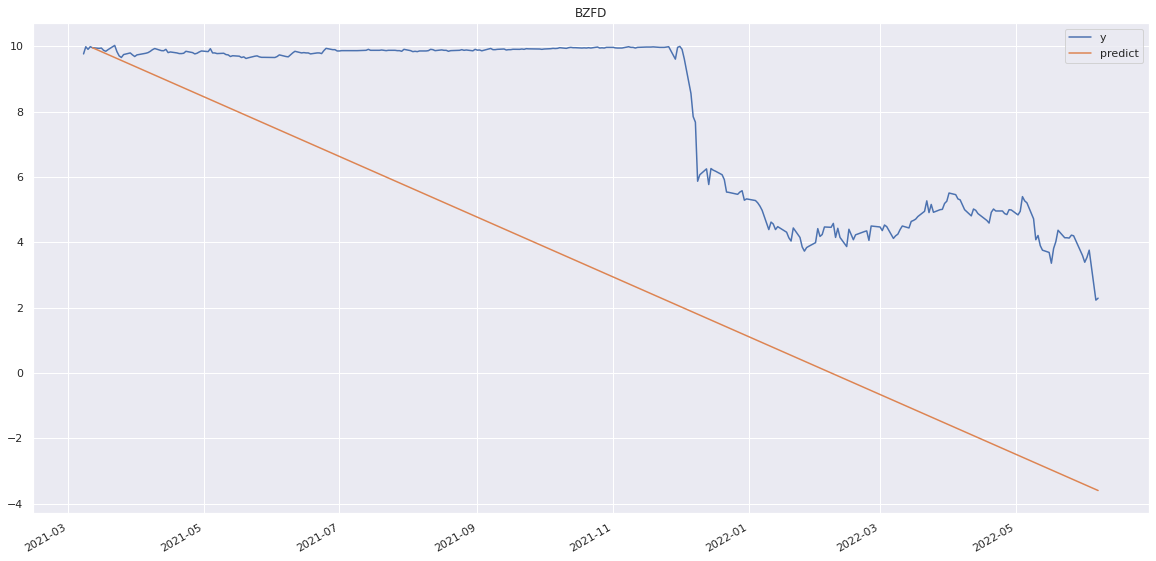

22:15:36 - cmdstanpy - INFO - Chain [1] start processing
22:15:36 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

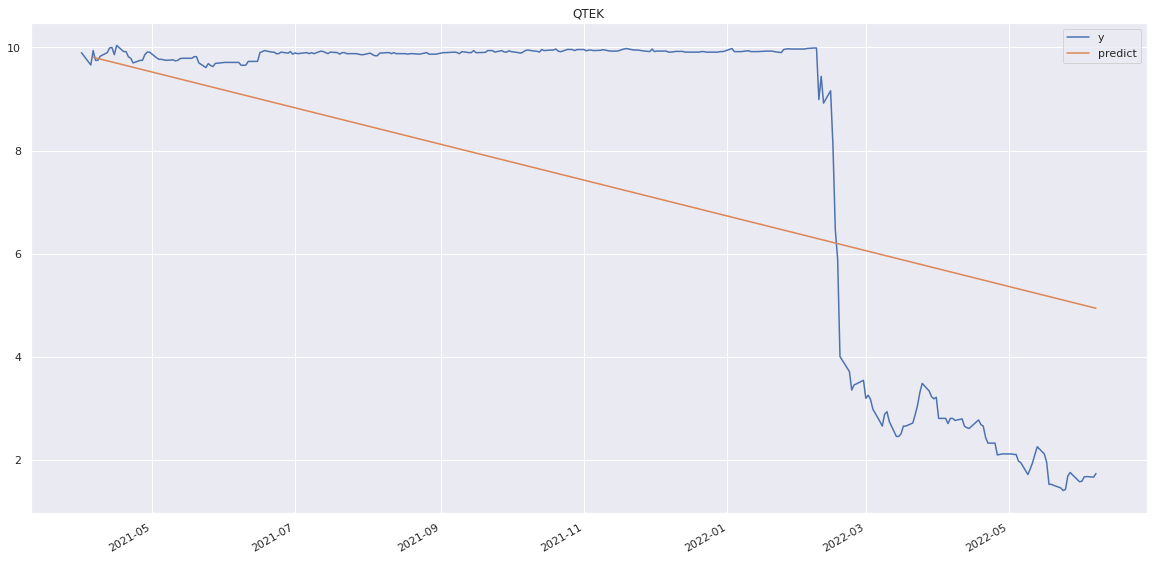

22:15:39 - cmdstanpy - INFO - Chain [1] start processing
22:15:39 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

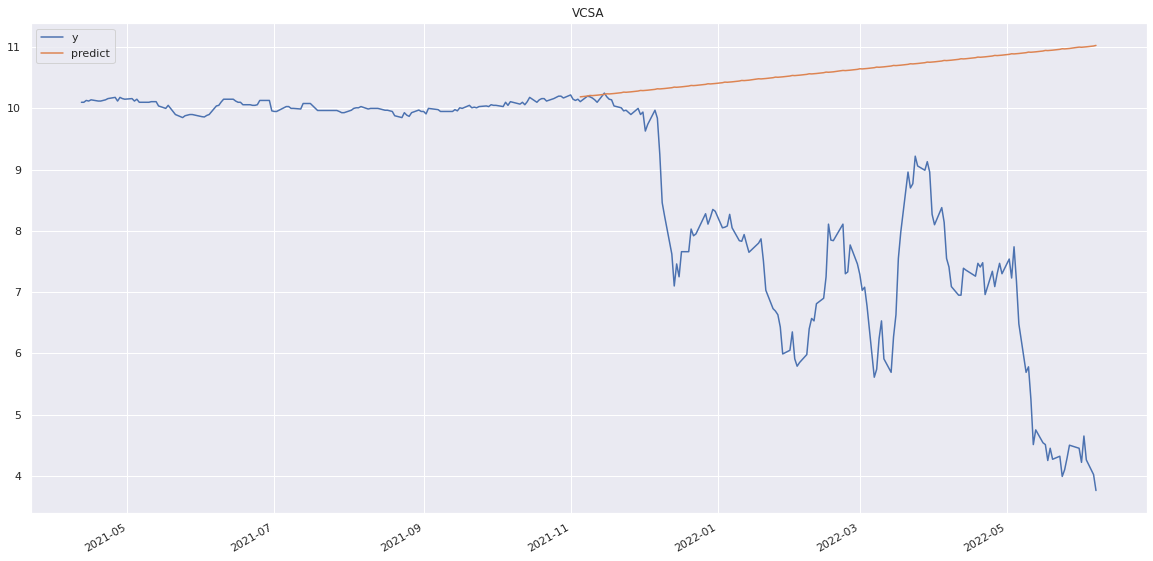

22:15:42 - cmdstanpy - INFO - Chain [1] start processing
22:15:42 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

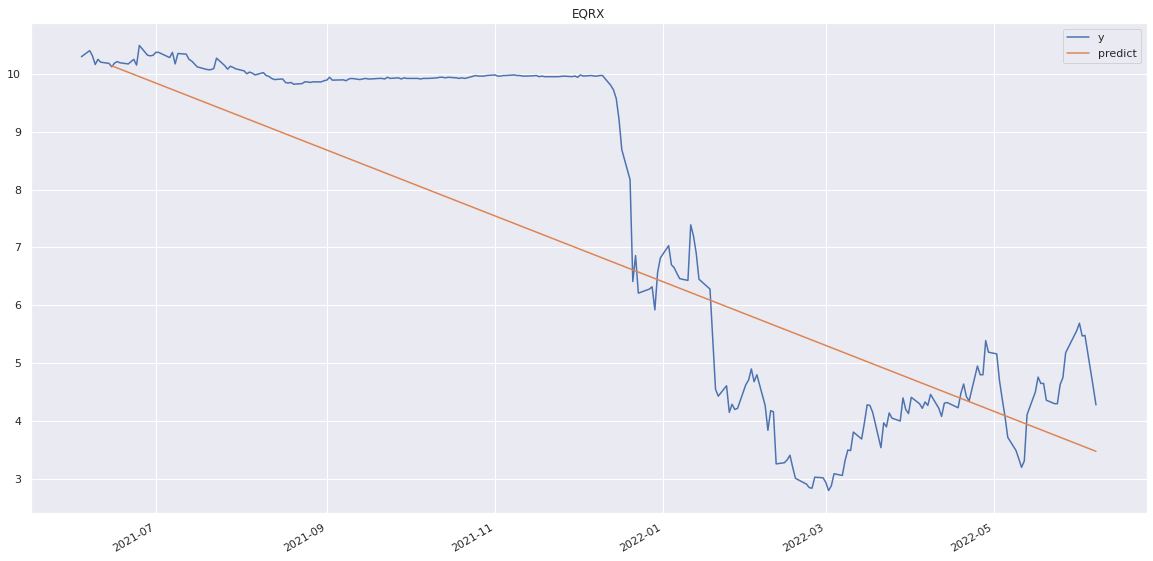

22:15:46 - cmdstanpy - INFO - Chain [1] start processing
22:15:46 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

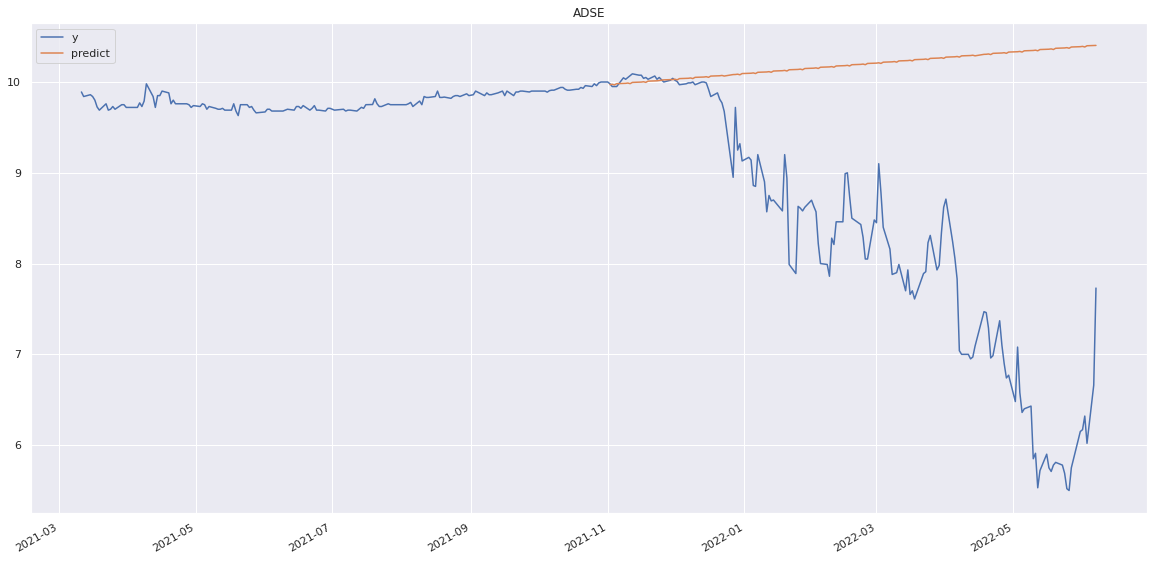

22:15:48 - cmdstanpy - INFO - Chain [1] start processing
22:15:48 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

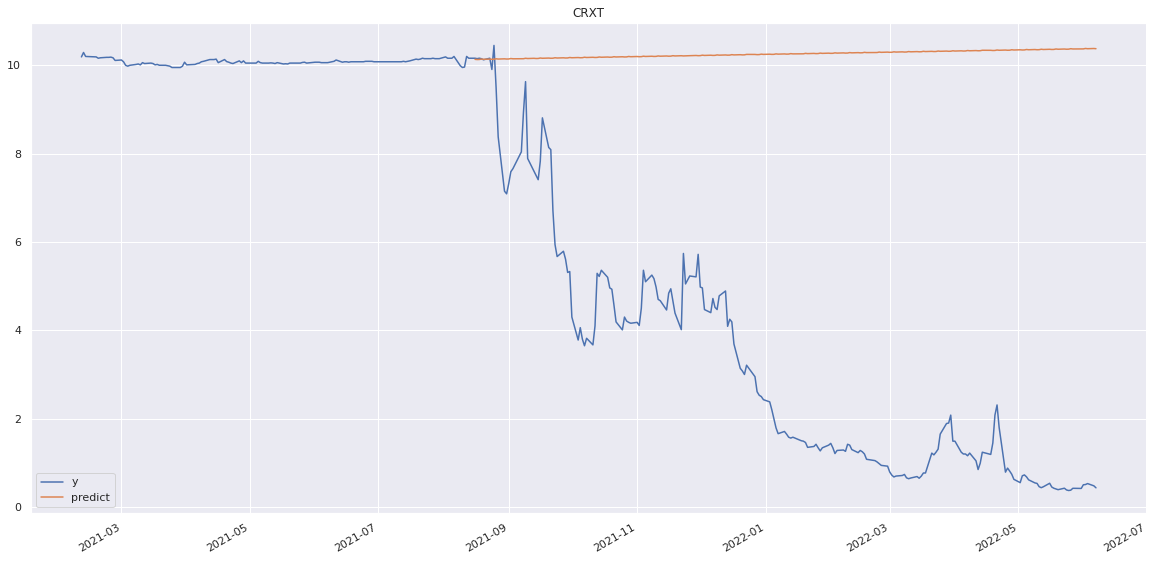

22:15:51 - cmdstanpy - INFO - Chain [1] start processing
22:15:55 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

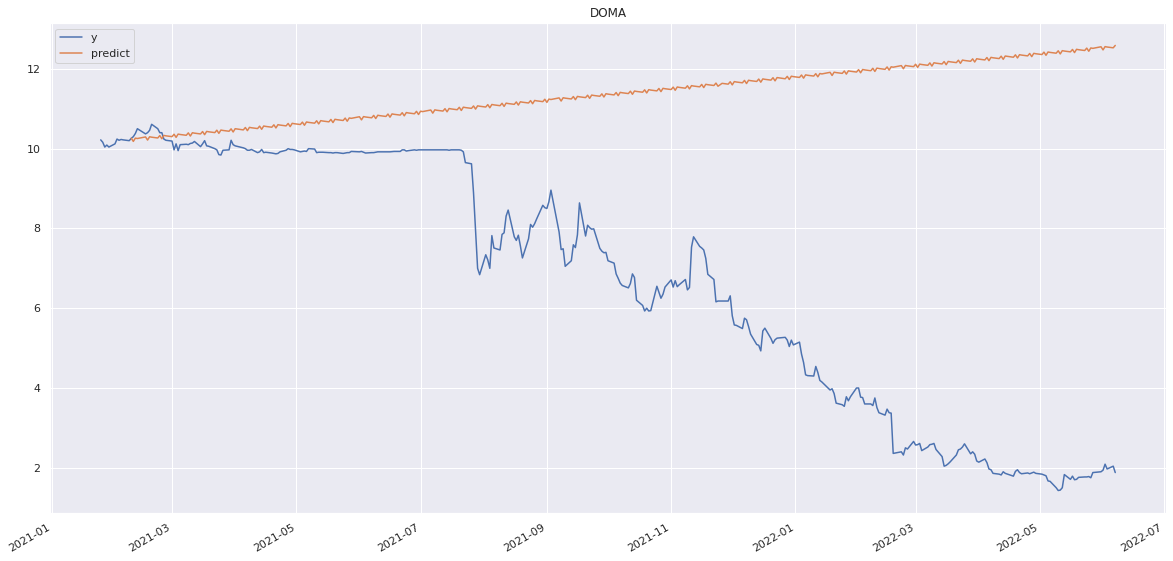

In [193]:
symbols = list(top.symbol.values[:10]) + list(bottom.symbol.values[:10])
for x in symbols:
  df = dfs[x]['data']
  df['y'] = df['close']
  df['ds'] = df.index
  df = df[['ds','y']]
  split = dfs[x]['max_price_date']-timedelta(days=10)
  train = df[:split]
  test = df[split:]
  m = Prophet()
  try:
    m.fit(train)
    predict = m.predict(test.drop(columns=['y']))
    df['predict'] = np.nan
    df['predict'][split:] = predict['yhat'].values
    ax = df[['y', 'predict']].plot()
    ax.set_title(x)
    plt.show()
  except:
    pass

Although there's no metric for accuracy it's easy to see the predictions are off by a lot, even when cheating and fiting the model using all of the SPAC's data the prediction is not able to hit the maximum price or anywhere near it.
although the general trend is similar to the overall behavior.
However unfortunatley this is still not usable

22:11:37 - cmdstanpy - INFO - Chain [1] start processing
22:11:37 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

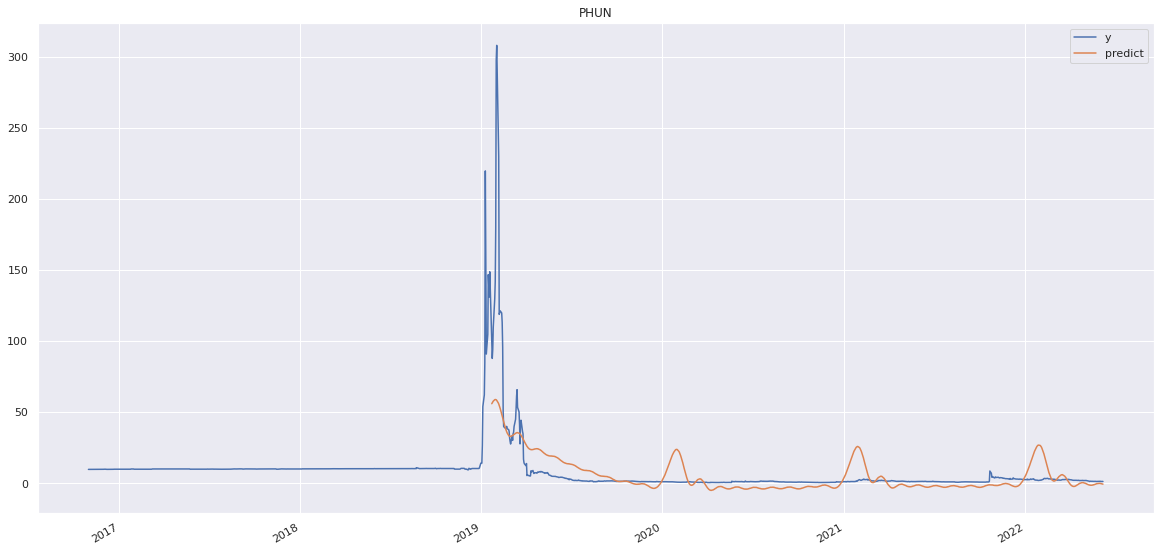

22:11:42 - cmdstanpy - INFO - Chain [1] start processing
22:11:42 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

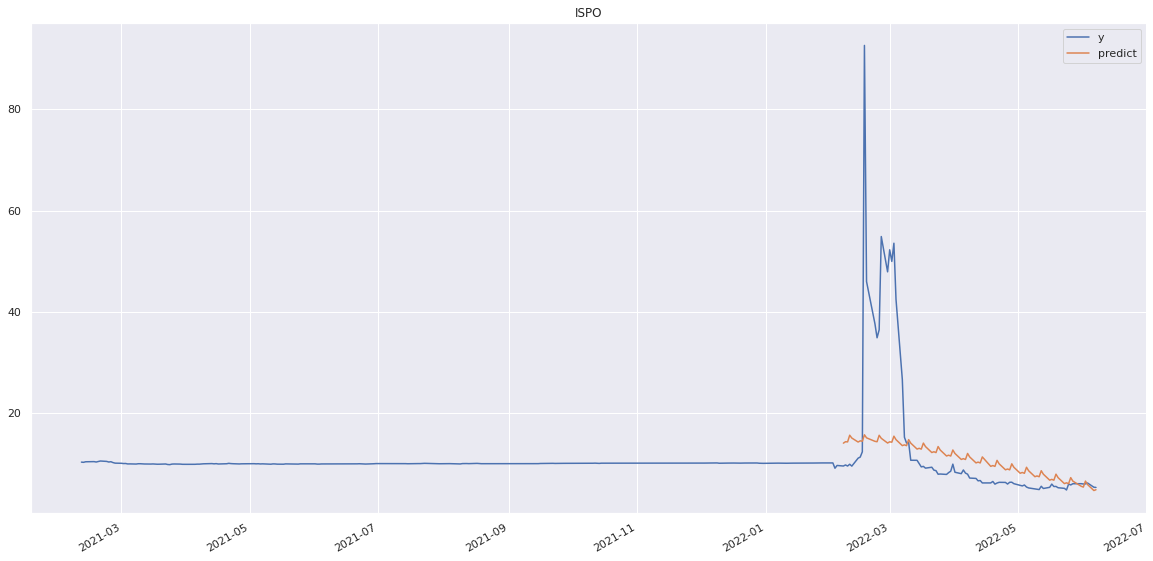

22:11:45 - cmdstanpy - INFO - Chain [1] start processing
22:11:45 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

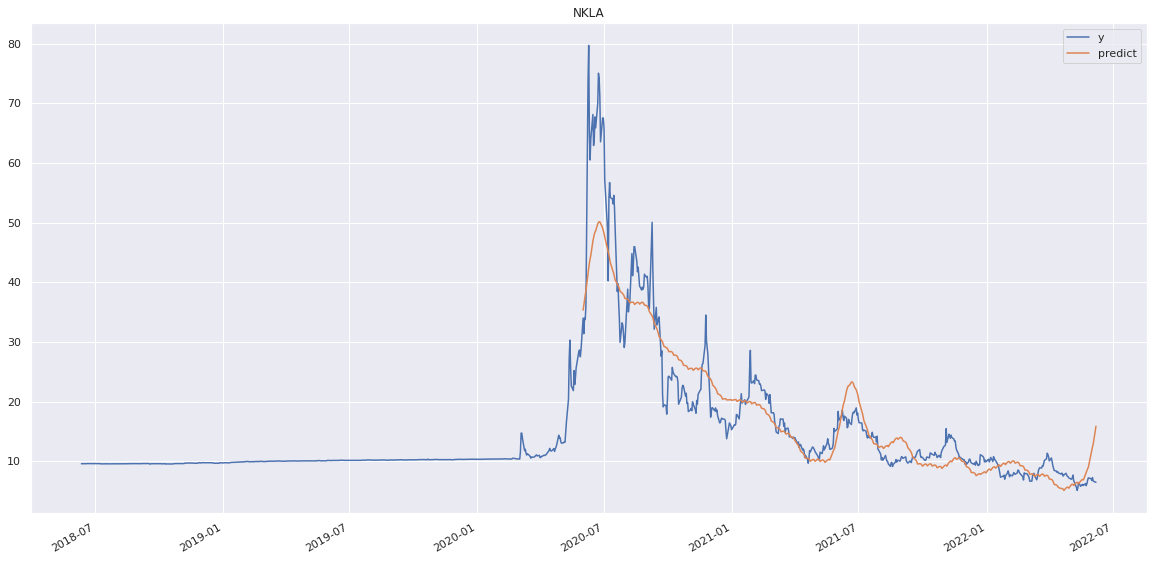

22:11:49 - cmdstanpy - INFO - Chain [1] start processing
22:11:49 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

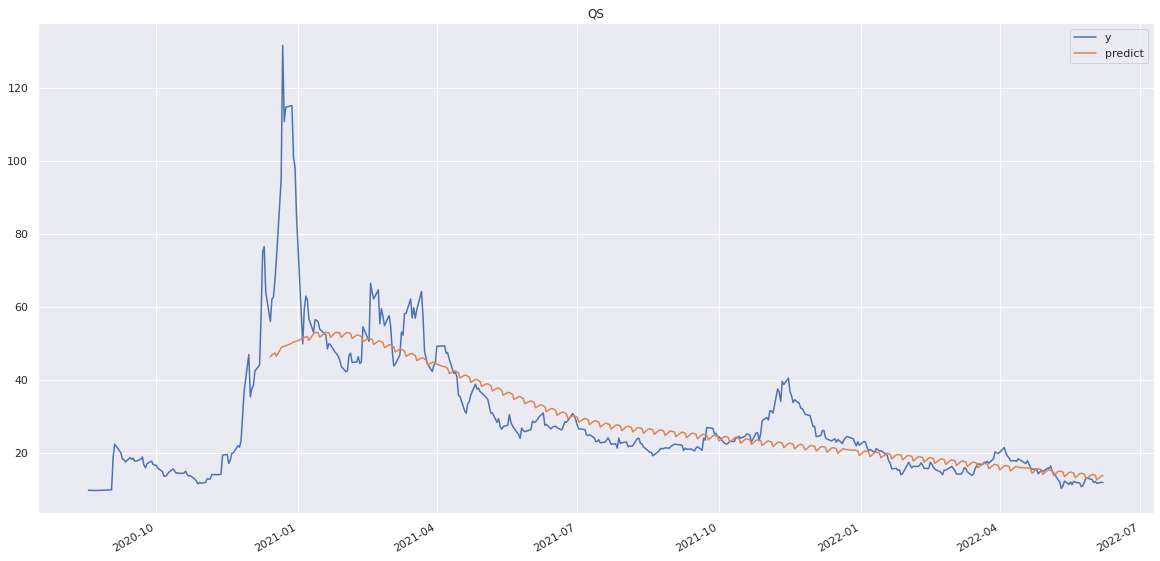

22:11:51 - cmdstanpy - INFO - Chain [1] start processing
22:11:52 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

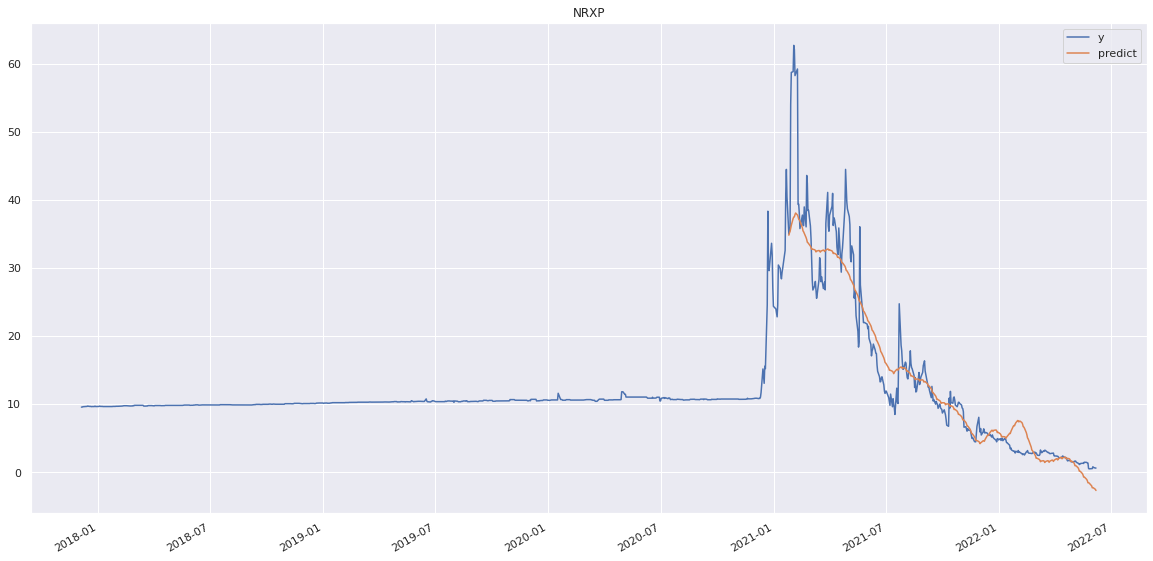

22:11:55 - cmdstanpy - INFO - Chain [1] start processing
22:11:56 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

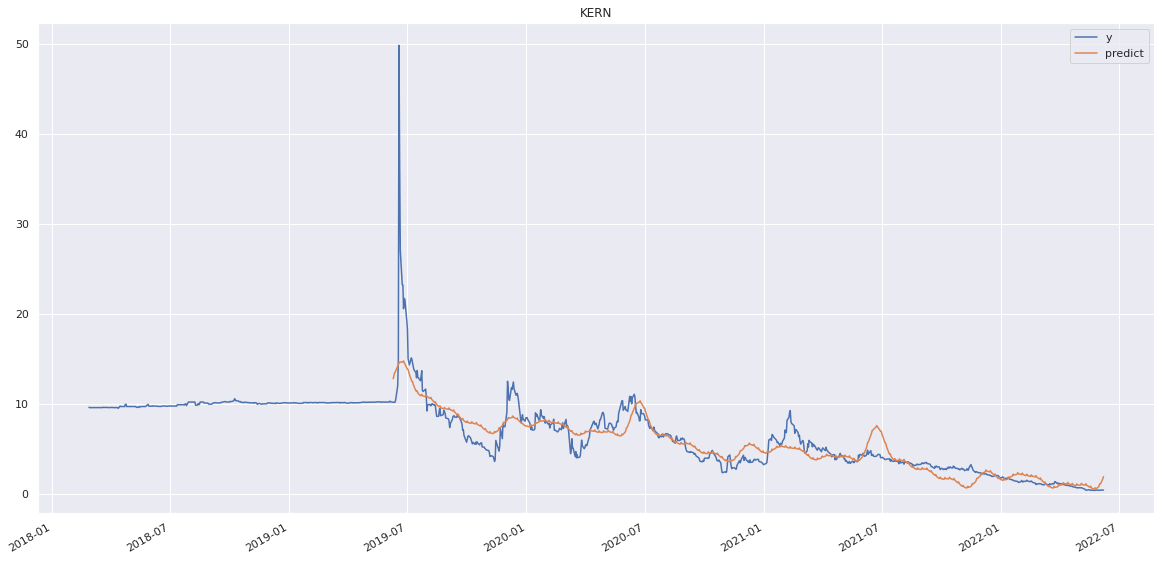

22:12:03 - cmdstanpy - INFO - Chain [1] start processing
22:12:03 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

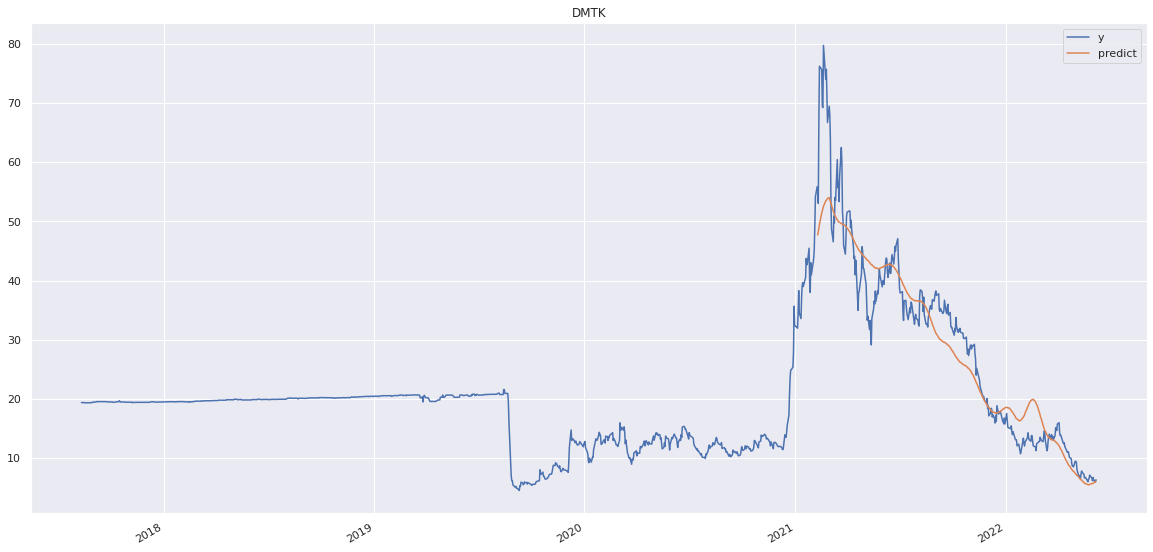

22:12:06 - cmdstanpy - INFO - Chain [1] start processing
22:12:06 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

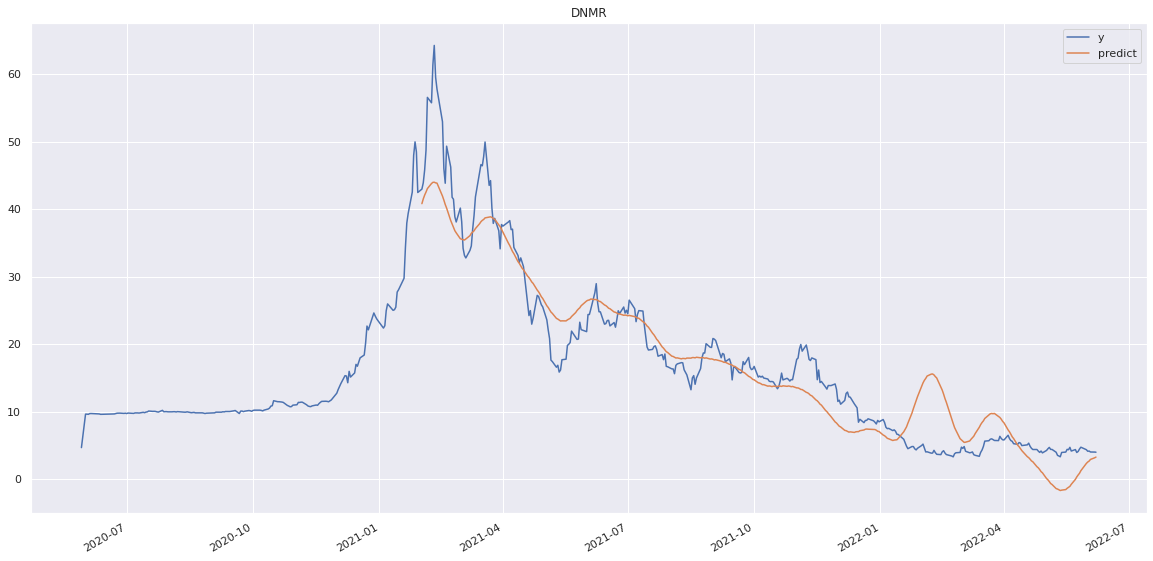

22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

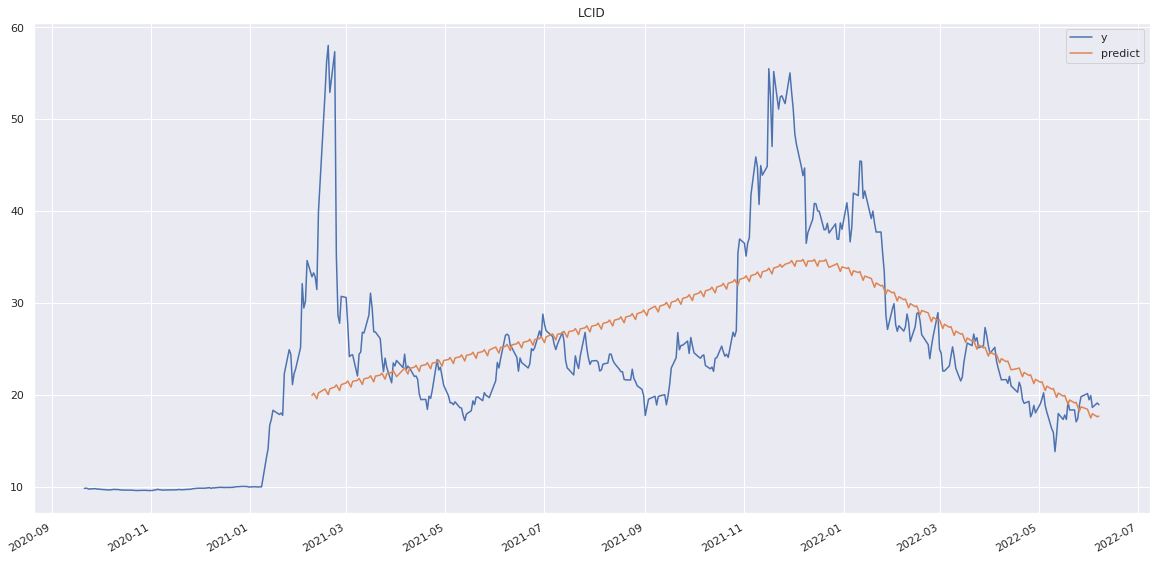

22:12:11 - cmdstanpy - INFO - Chain [1] start processing
22:12:11 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

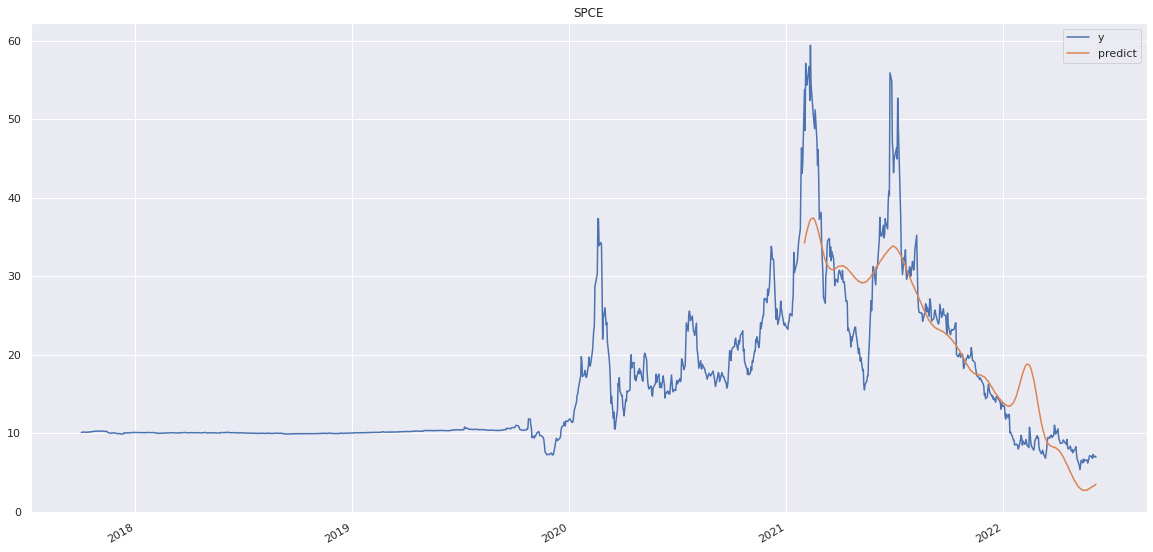

22:12:13 - cmdstanpy - INFO - Chain [1] start processing
22:12:13 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

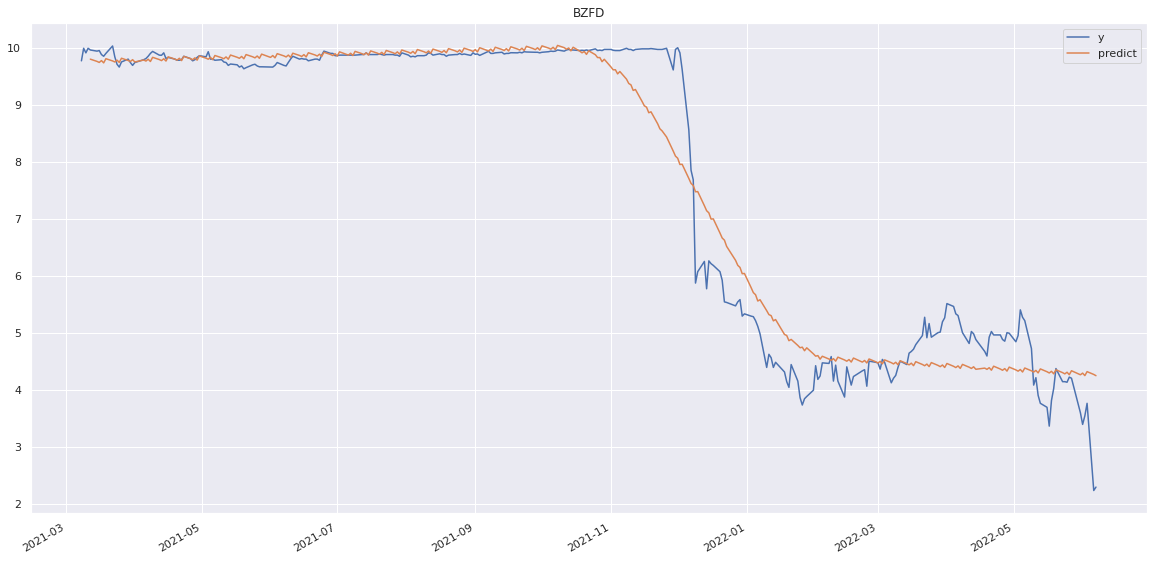

22:12:16 - cmdstanpy - INFO - Chain [1] start processing
22:12:16 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

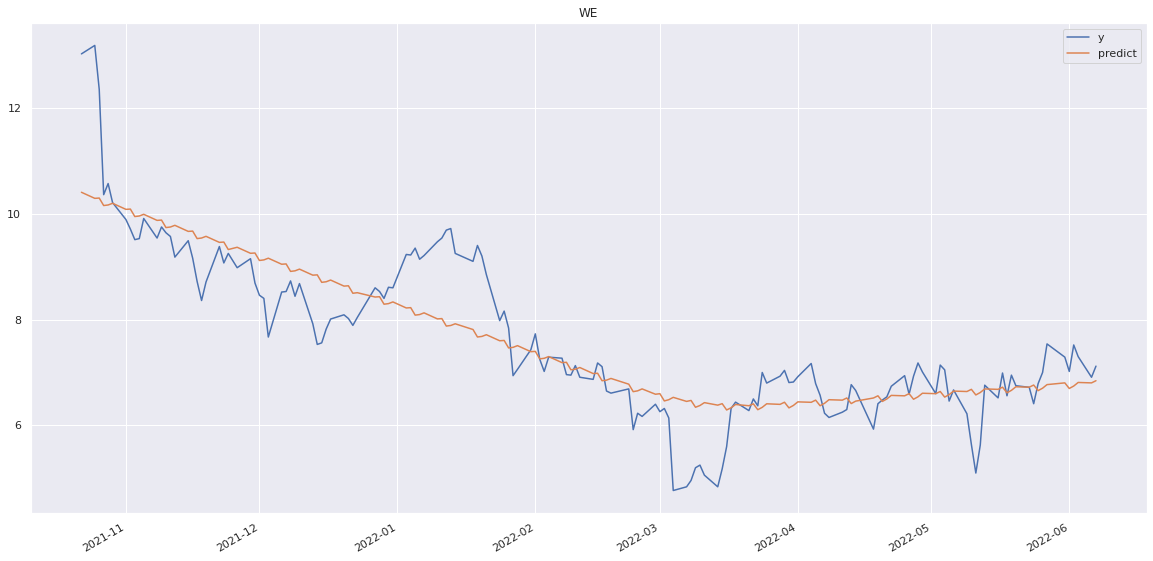

22:12:18 - cmdstanpy - INFO - Chain [1] start processing
22:12:18 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

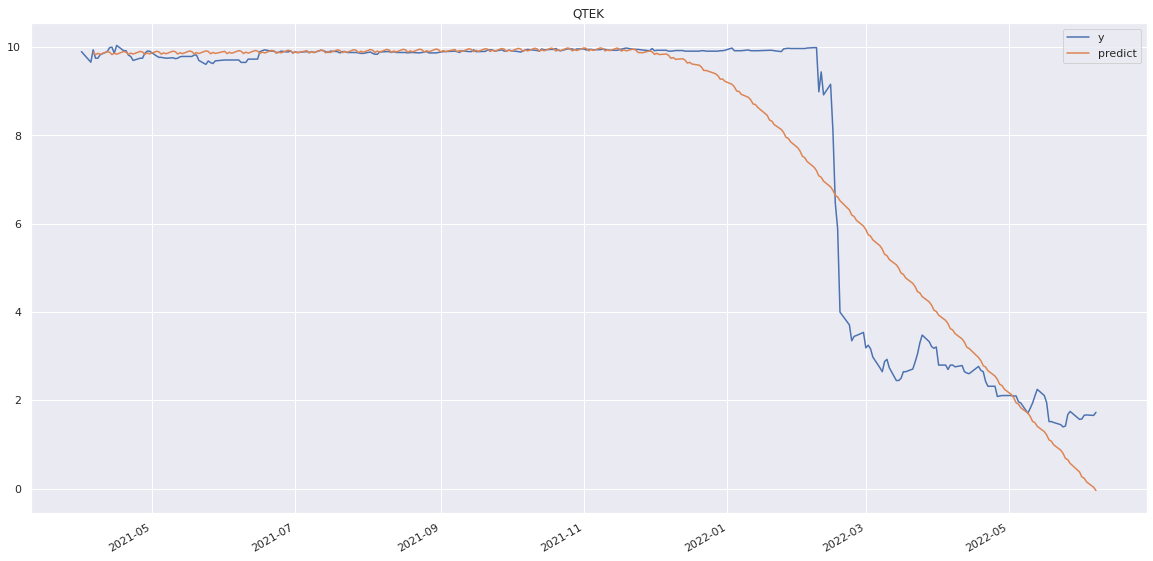

22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

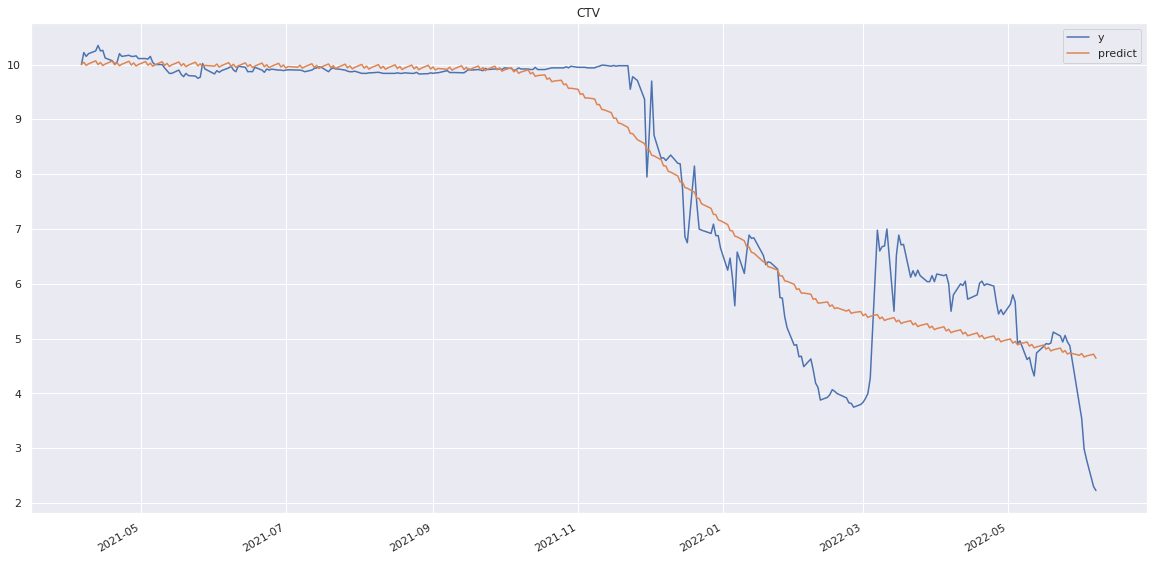

22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

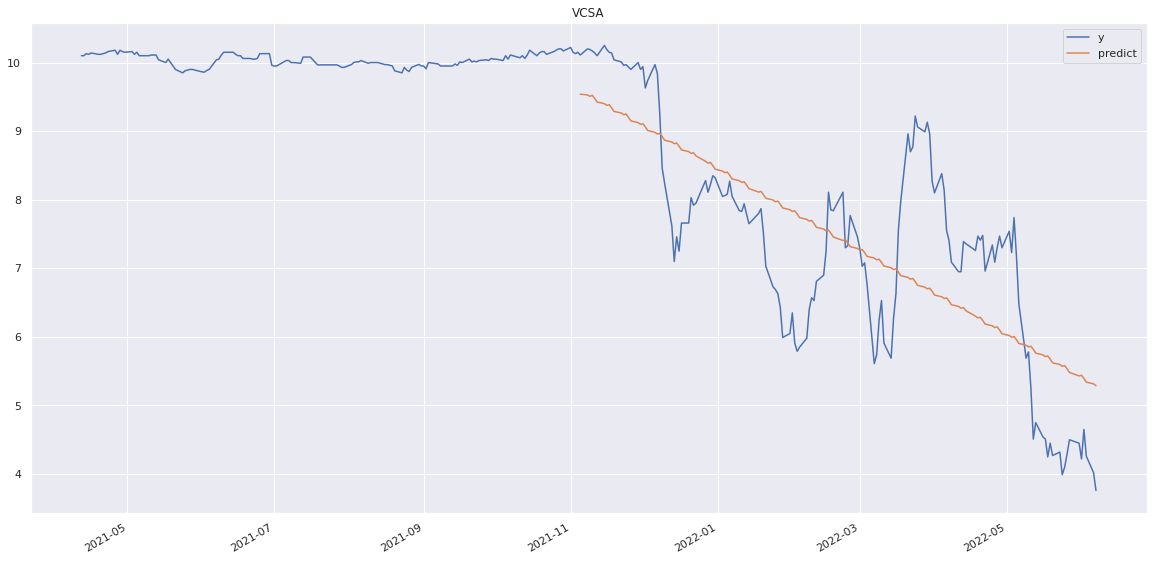

22:12:25 - cmdstanpy - INFO - Chain [1] start processing
22:12:25 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

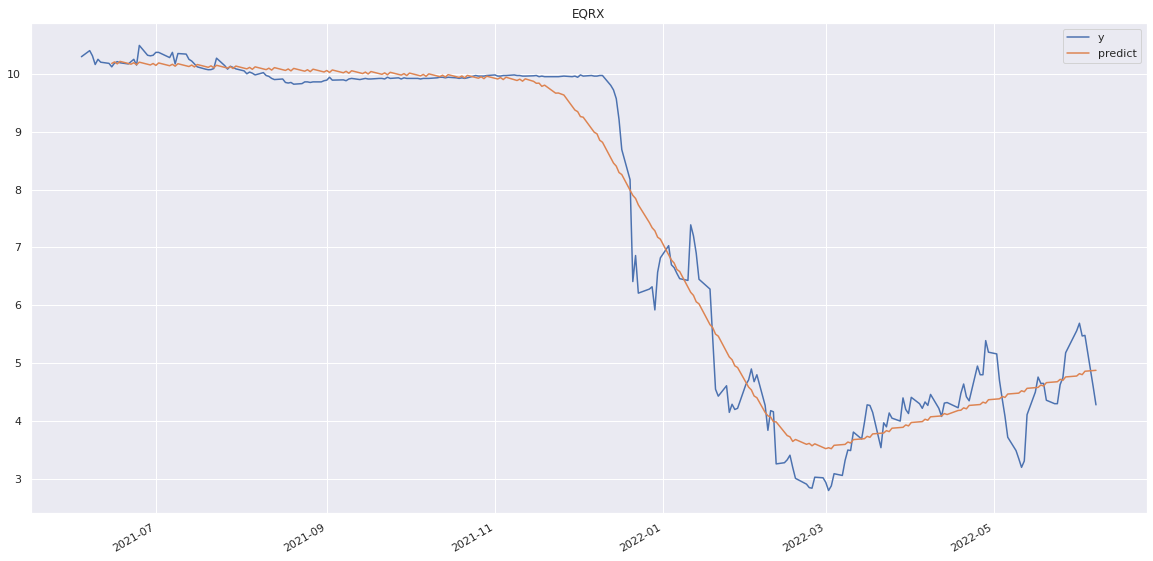

22:12:27 - cmdstanpy - INFO - Chain [1] start processing
22:12:27 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

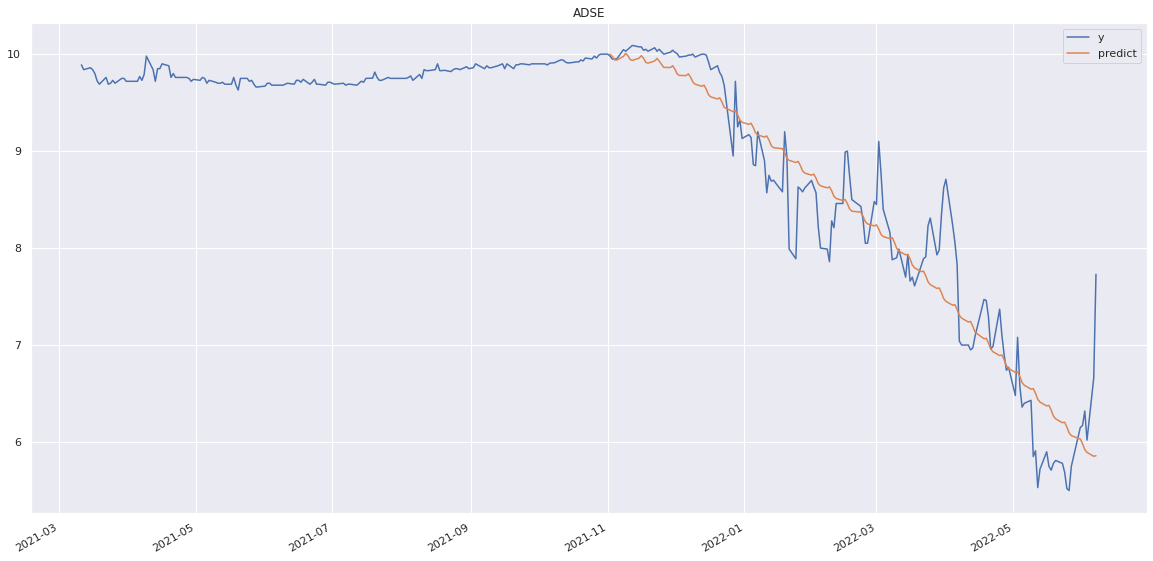

22:12:29 - cmdstanpy - INFO - Chain [1] start processing
22:12:30 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

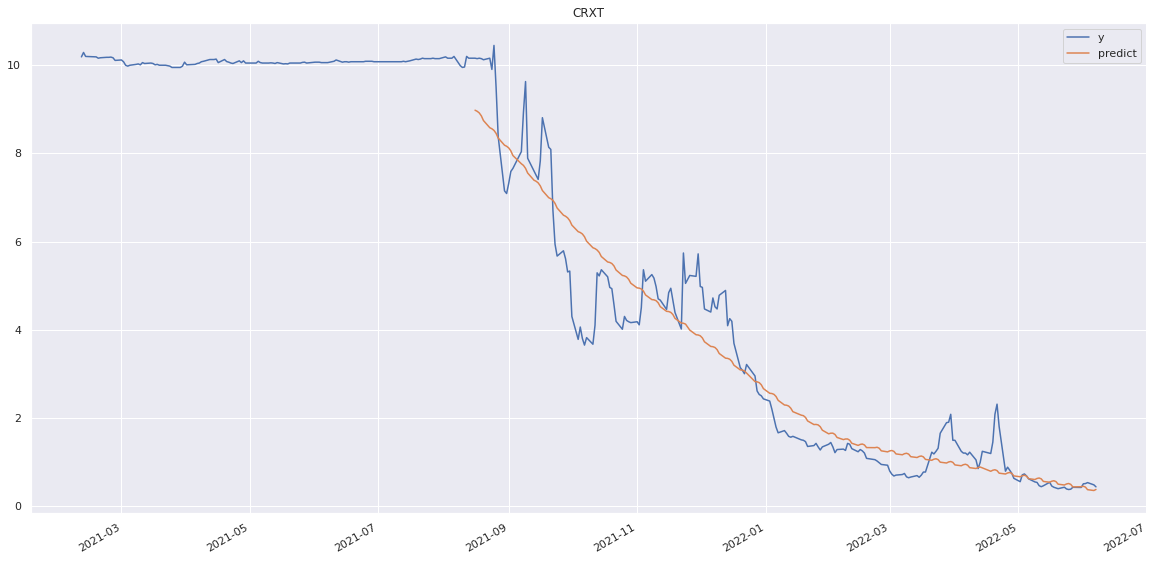

22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

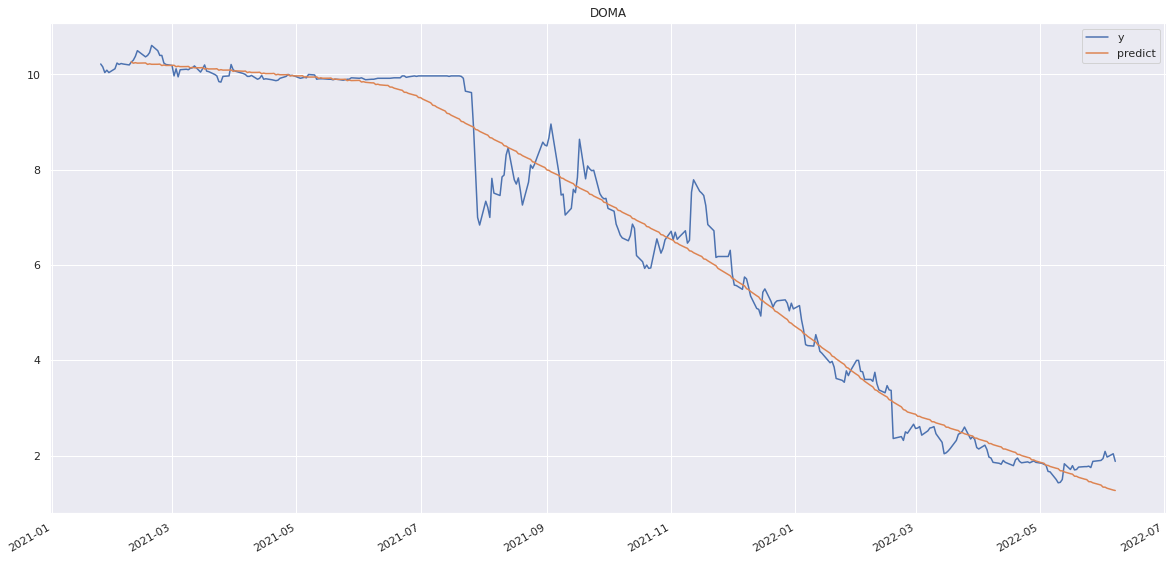

22:12:34 - cmdstanpy - INFO - Chain [1] start processing
22:12:34 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

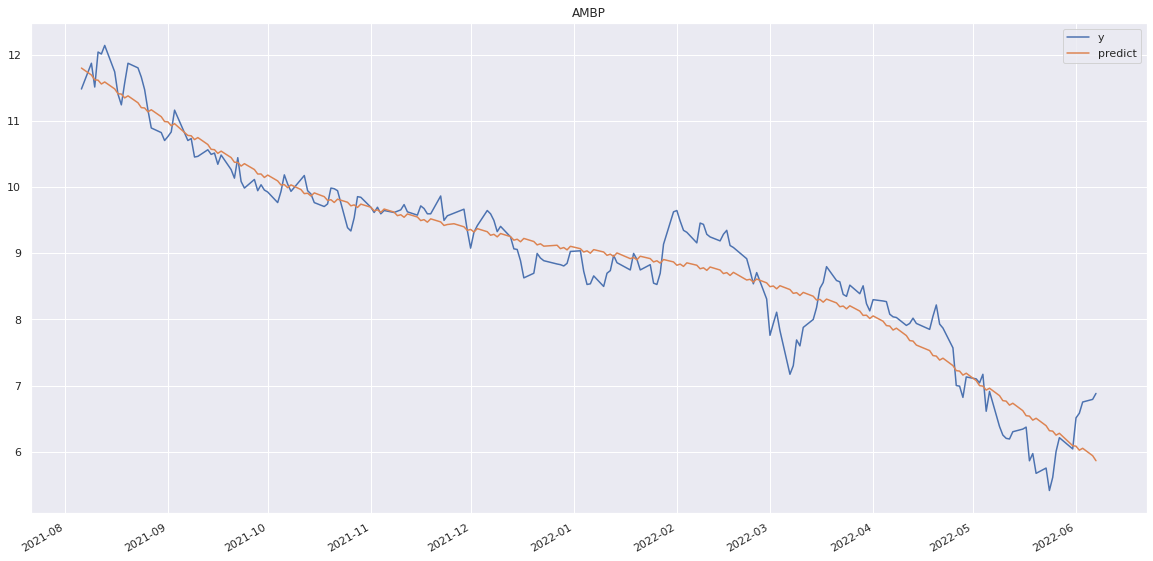

In [192]:
# m = Prophet()
for x in symbols:
  df = dfs[x]['data']
  df['y'] = df['close']
  df['ds'] = df.index
  df = df[['ds','y']]
  split = dfs[x]['max_price_date']-timedelta(days=10)
  train = df[:split]
  test = df[split:]
  m = Prophet()
  try:
    m.fit(df)
    predict = m.predict(test.drop(columns=['y']))
    df['predict'] = np.nan
    df['predict'][split:] = predict['yhat'].values
    ax = df[['y', 'predict']].plot()
    ax.set_title(x)
    plt.show()
  except:
    pass